# StarDist Training Notebook demo, Sept 2024
## This notebook will walk you through using the demo model, and how the training works including:
* Data Augmentation
* Train/Test split
* Number of rays
* Metrics
* Tau


In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import os
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize, download_and_extract_zip_file


from stardist import fill_label_holes, relabel_image_stardist, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

/tmp/slurm_8905904/ipykernel_157662/108201305.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None
2024-09-06 16:02:16.854995: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
#Check to see if GPU is enabled
gputools_available()

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


True

# Data

This code block downloads the sample data from the internet, specifically the github repository from the authors

### When formatting your data for training, pay careful attention to how the data is formatted in the sample case. You will want to name your images in the same manner.

### Note! Labels that are made by humans are typically called the "ground truth"

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [3]:
download_and_extract_zip_file(
    url       = 'https://github.com/stardist/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files found, nothing to download.


In [4]:
X = sorted(glob('data/dsb2018/train/images/*.tif'))
Y = sorted(glob('data/dsb2018/train/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [5]:
print('The first three label images are: ',*X[0:3], sep='\n')
print('')
print('The first three label images are: ',*Y[0:3], sep='\n')

The first three label images are: 
data/dsb2018/train/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.tif
data/dsb2018/train/images/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1.tif
data/dsb2018/train/images/0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21.tif

The first three label images are: 
data/dsb2018/train/masks/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.tif
data/dsb2018/train/masks/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1.tif
data/dsb2018/train/masks/0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21.tif


In [6]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Normalize images and fill small label holes.

In [7]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|████████████████████████████████████████| 447/447 [00:01<00:00, 227.74it/s]


In [9]:

assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 447
- training:       380
- validation:      67


### Training data consists of pairs of input image and label instances.

In [10]:

def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

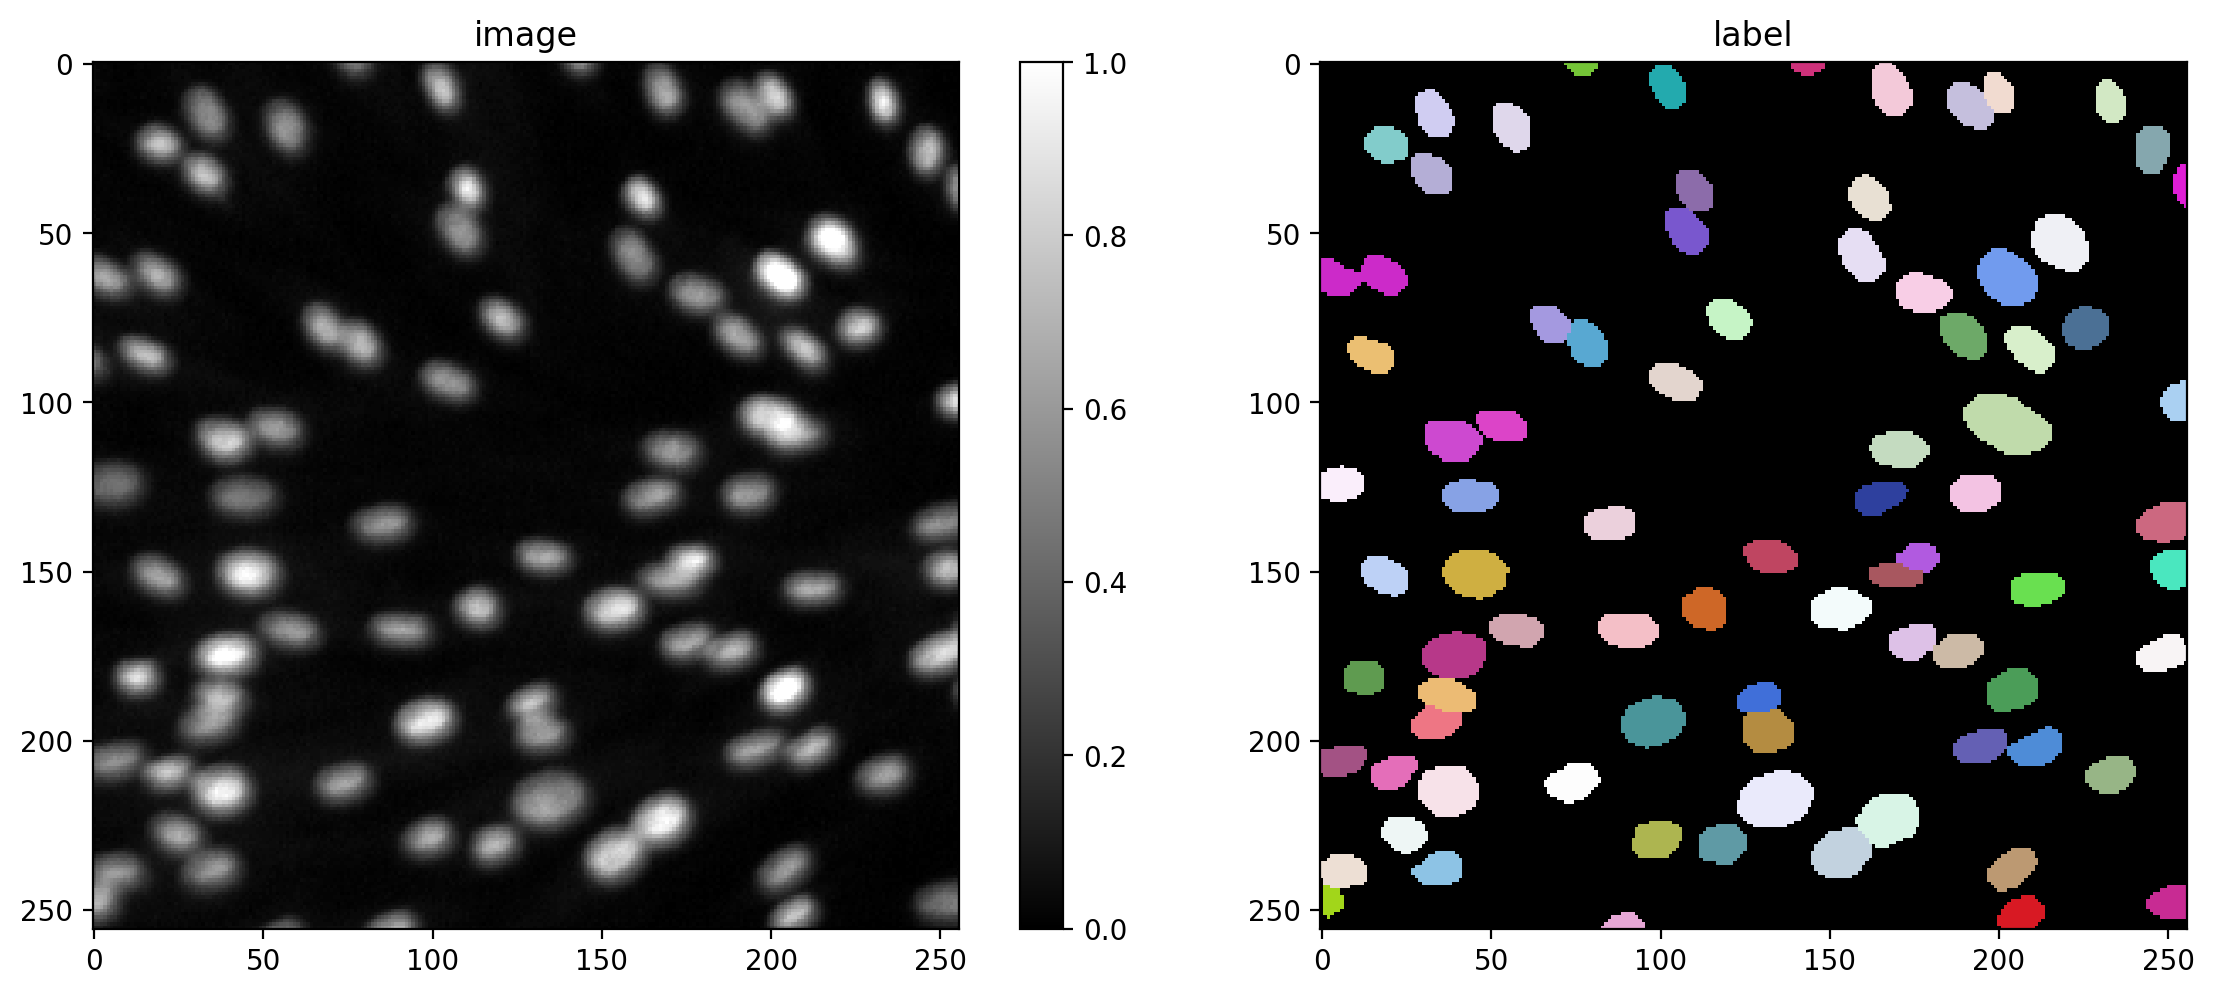

In [10]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [11]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class prediction (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

# Example image


# See an image with it's ground truth labels

In [12]:
##Make up list of images and their labels

i = min(4, len(X)-1)
img, lbl = X[i], fill_label_holes(Y[i])
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
# assumed axes ordering of img and lbl is: YX(C)

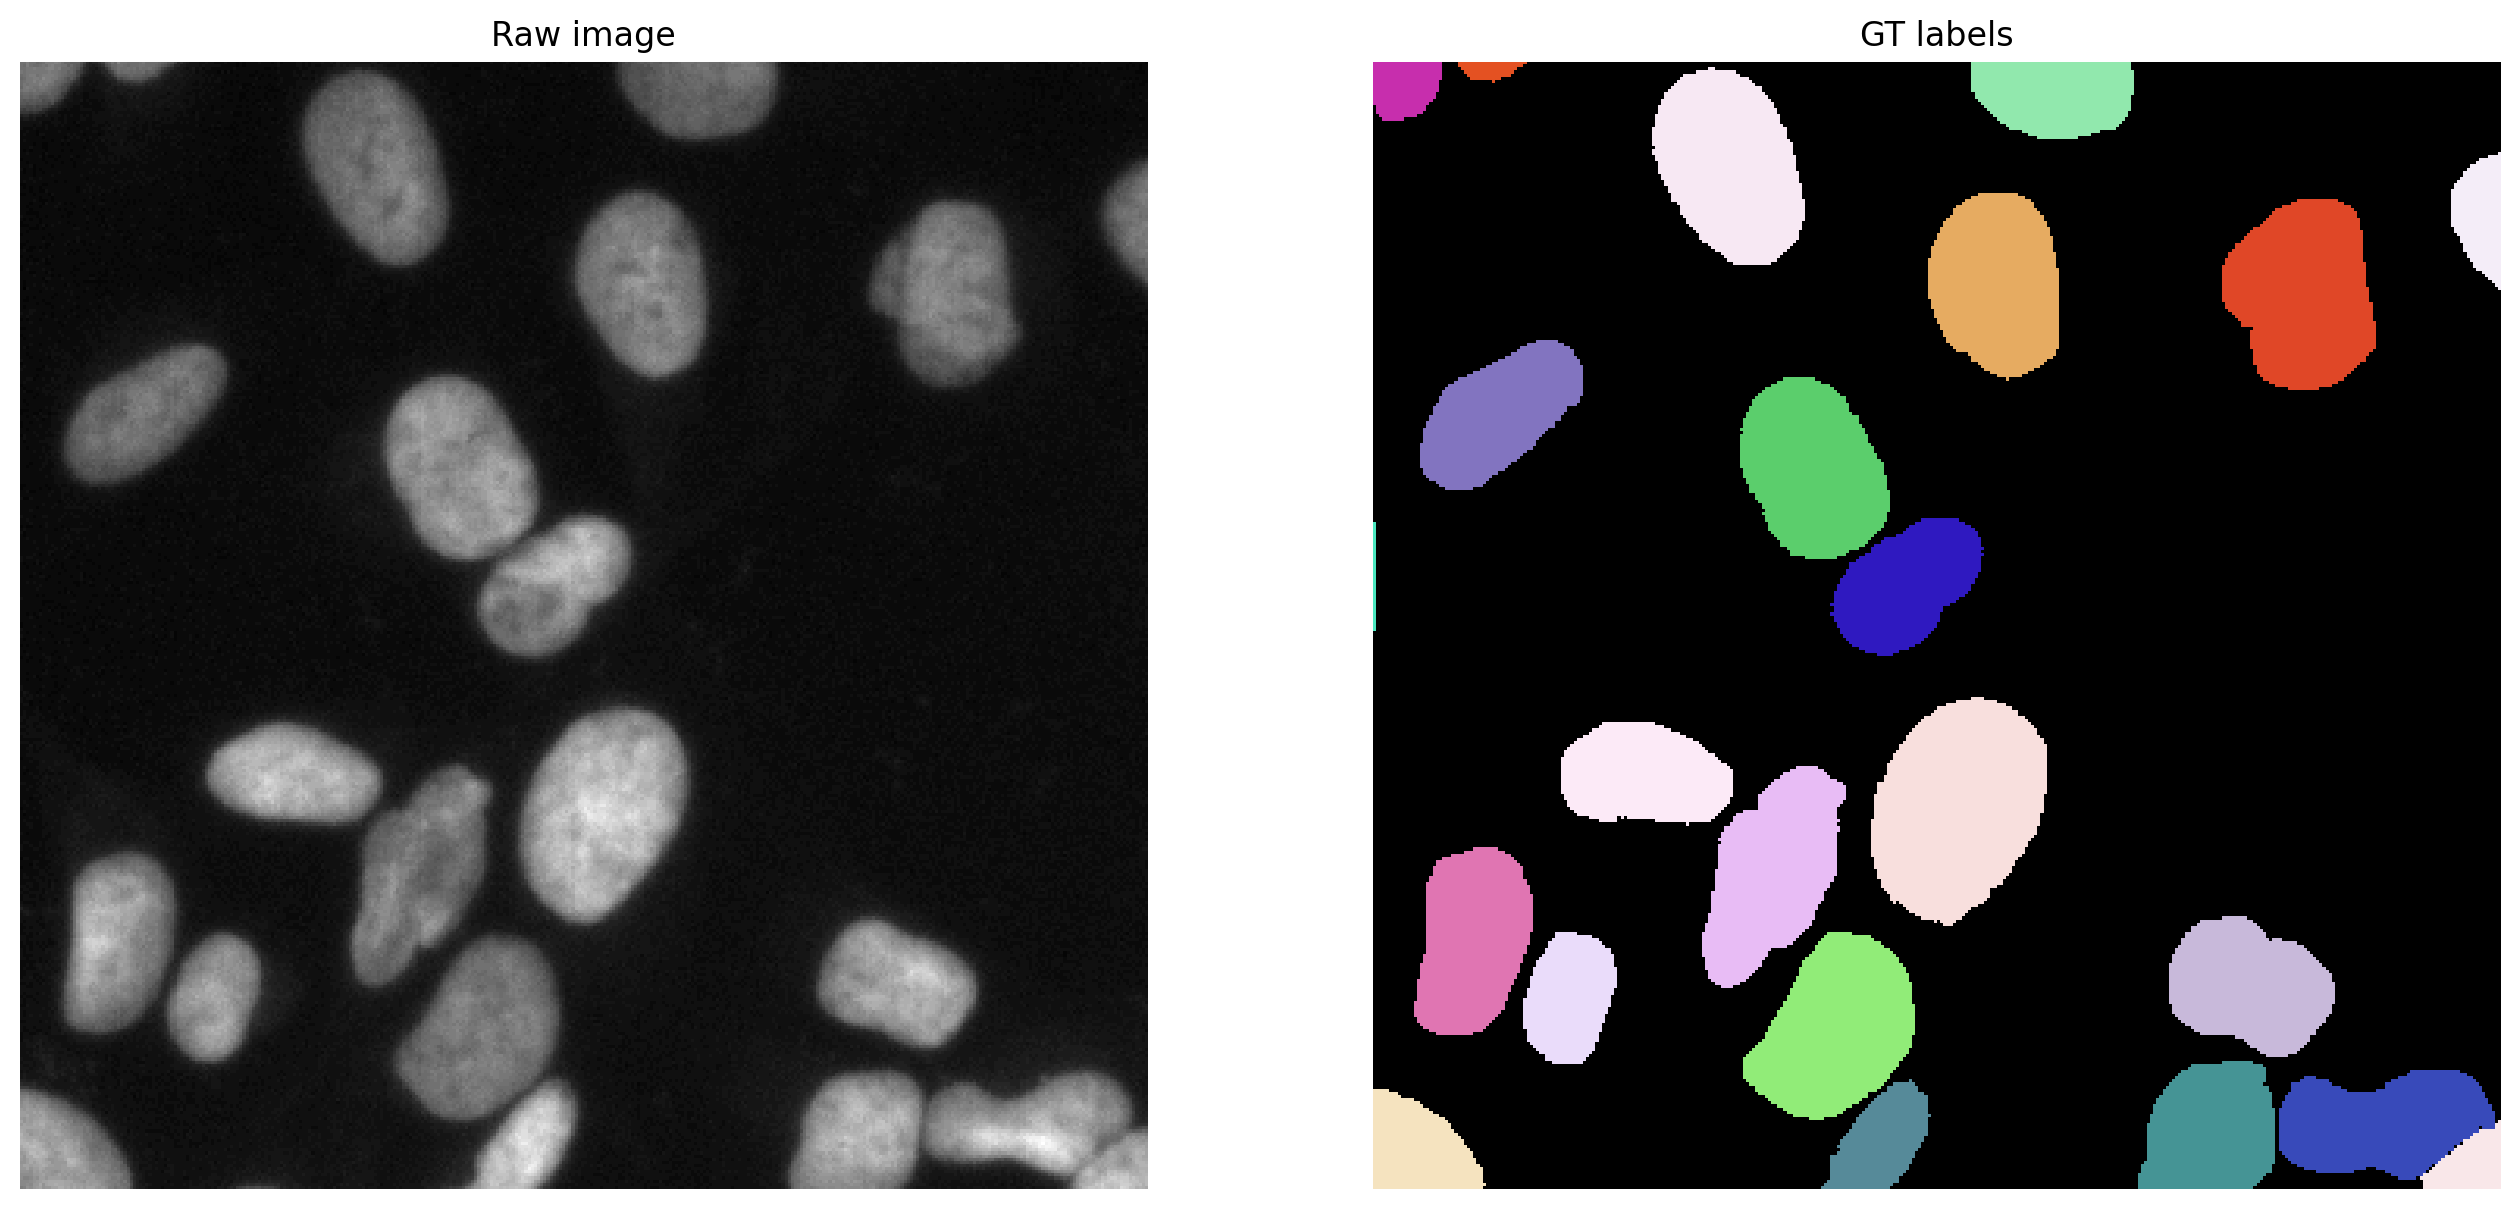

In [13]:
#plot the image

plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

# Fitting ground-truth labels with star-convex polygons

## Rays
### StarDist uses rays from a central point to map out the perimeter of the object.  The more rays coming out, the closer to actual the perimeter will be.  There is a compromise to be made though, the more rays you have, the slower the training will be

#### This will show us if the objects can be fit by star-convex polygons

In [14]:
## Generate images with different number of rays from 2^1 to 2^8
## with 250GB, will take about 1 minute 30 seconds on gpu

n_rays = [2**i for i in range(2,8)]
scores = []
for r in tqdm(n_rays):
    Y_reconstructed = [relabel_image_stardist(lbl, n_rays=r) for lbl in Y]
    mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
    scores.append(mean_iou)

100%|█████████████████████████████████████████████| 6/6 [01:38<00:00, 16.45s/it]


## Here we can see how well we reconstruct the ground truth labels with varying amount of rays.  Obviously four is too few rays, but as we increase the number of rays after a certain point, we get diminishing returns

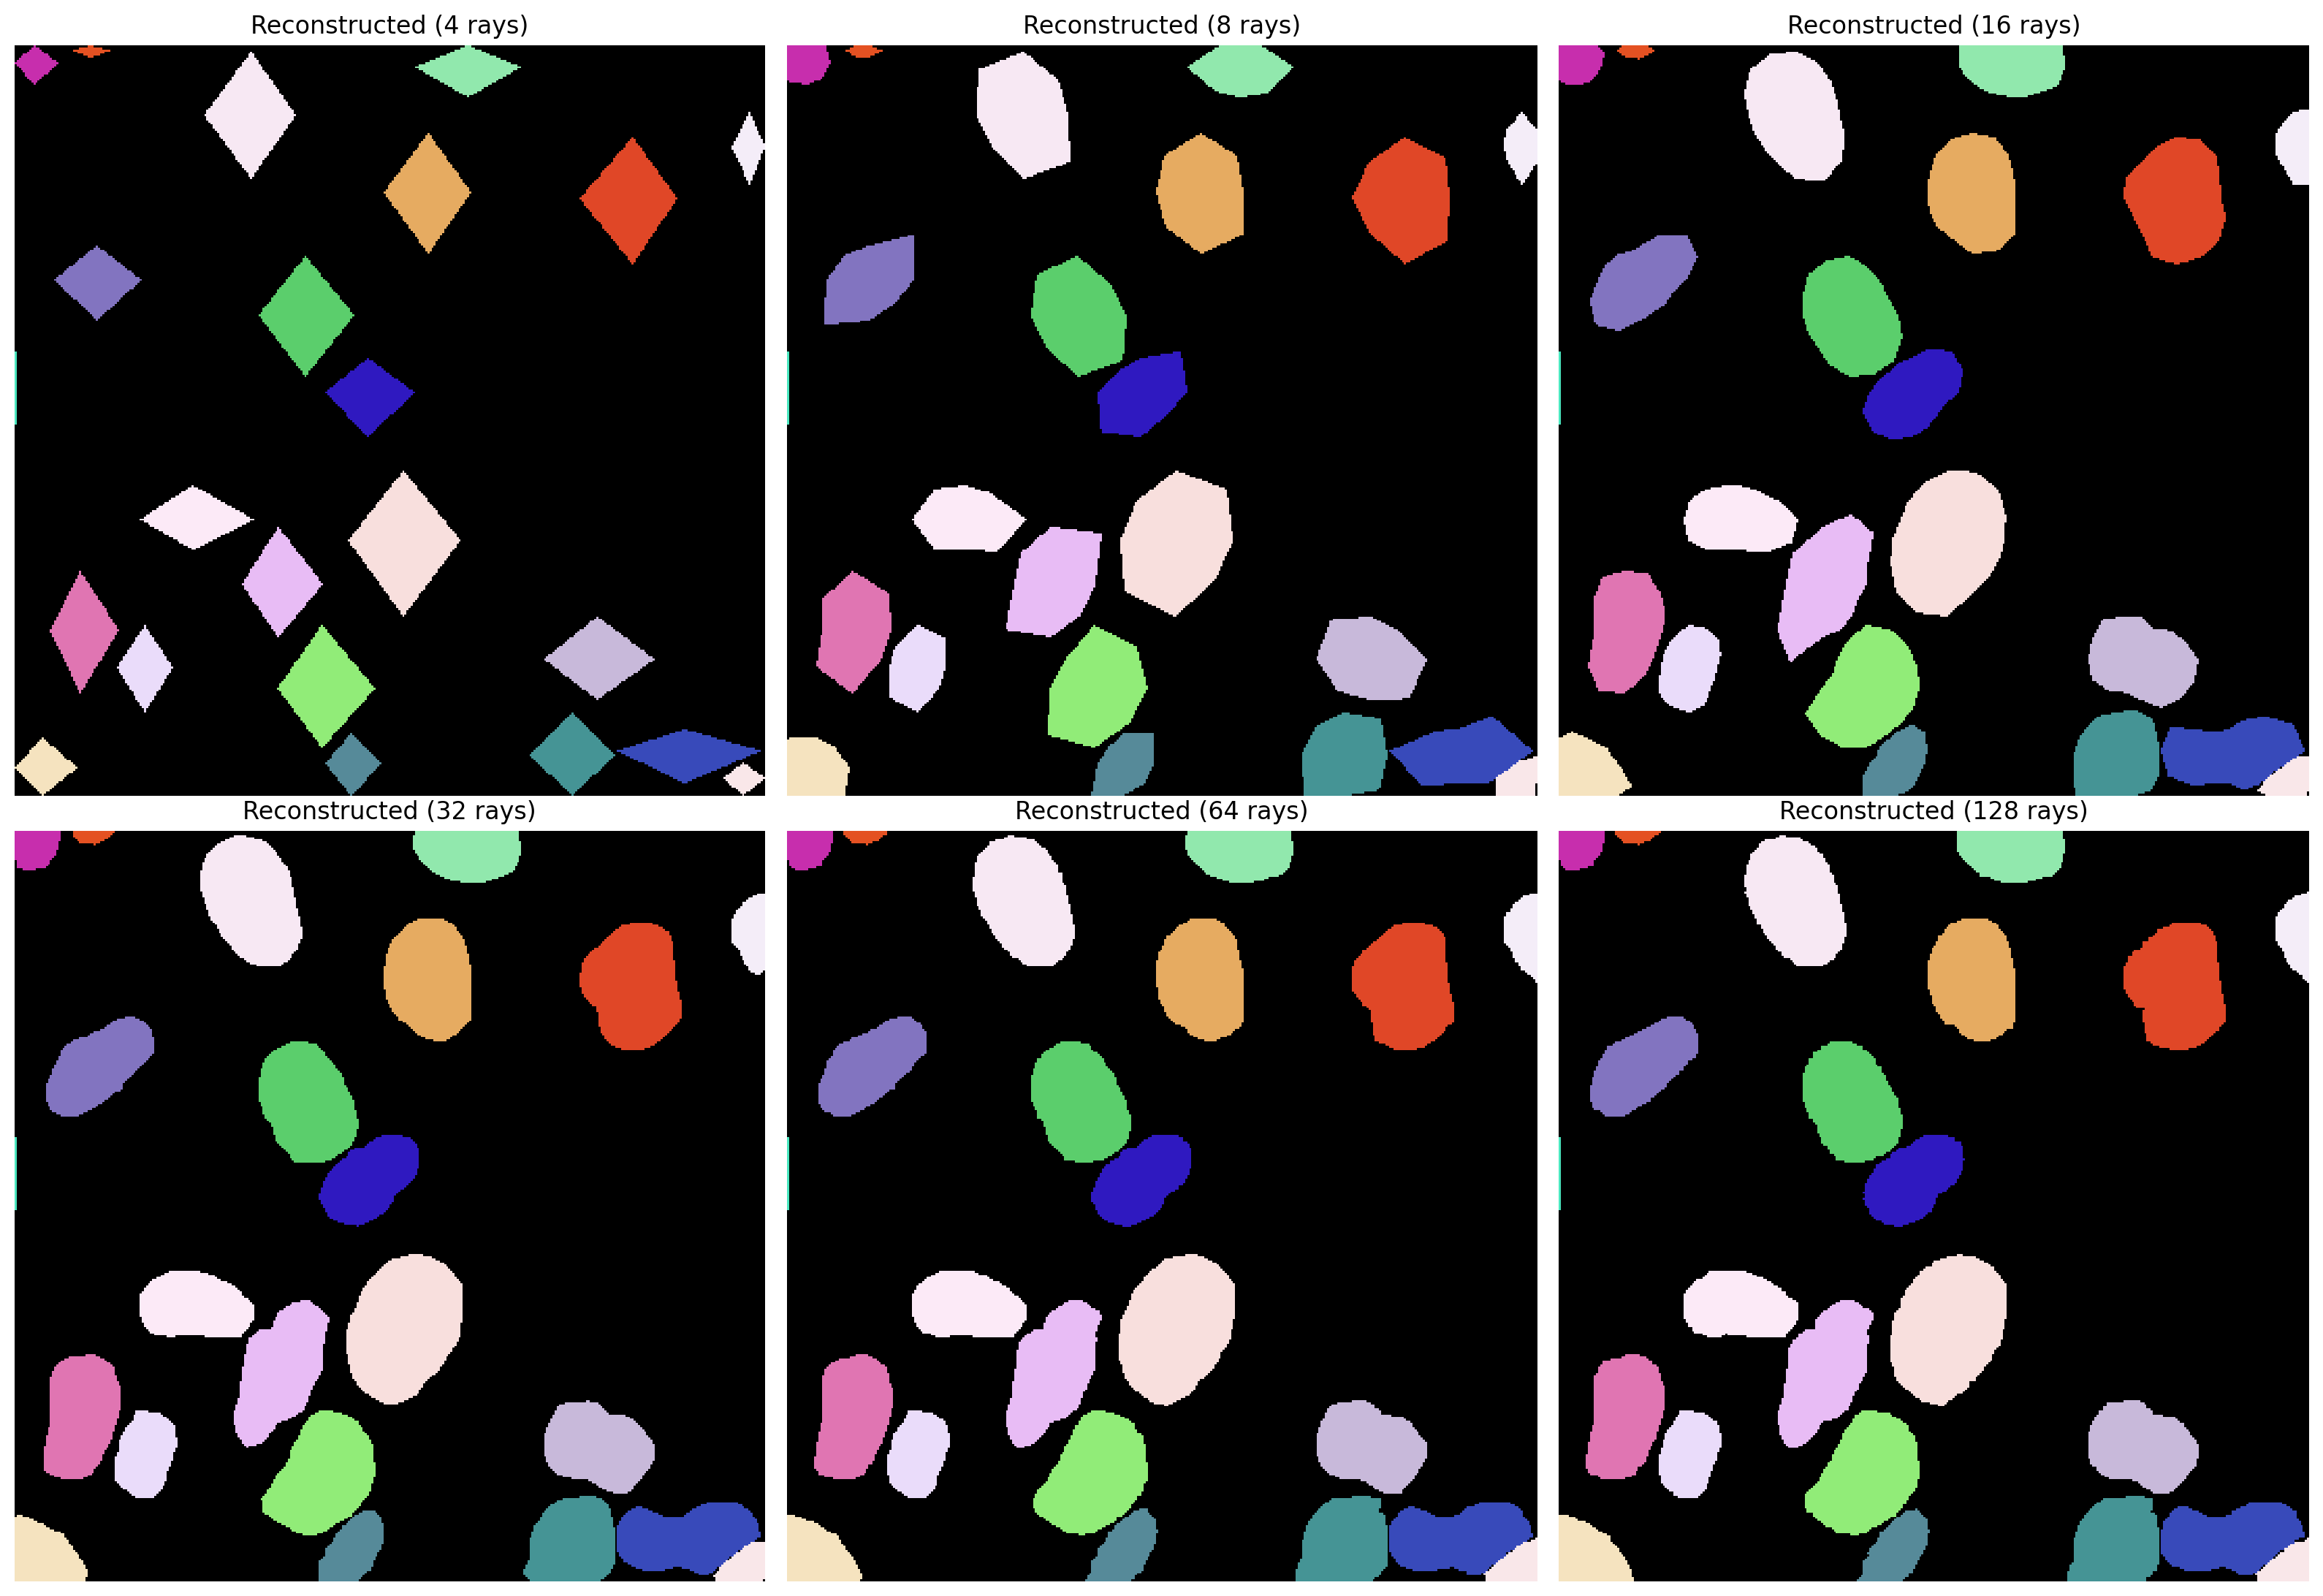

In [15]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    a.imshow(relabel_image_stardist(lbl, n_rays=r), cmap=lbl_cmap)
    a.set_title('Reconstructed (%d rays)' % r)
    a.axis('off')
plt.tight_layout();

## Intersection over union
 The traditional measure of the how well a label fits to a ground truth is by measuring the intersection over union. 
 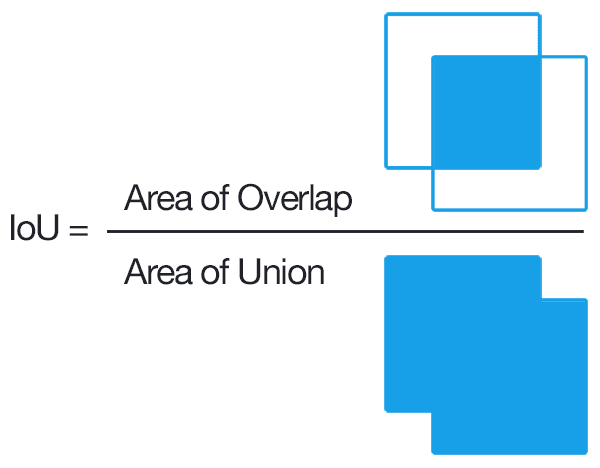

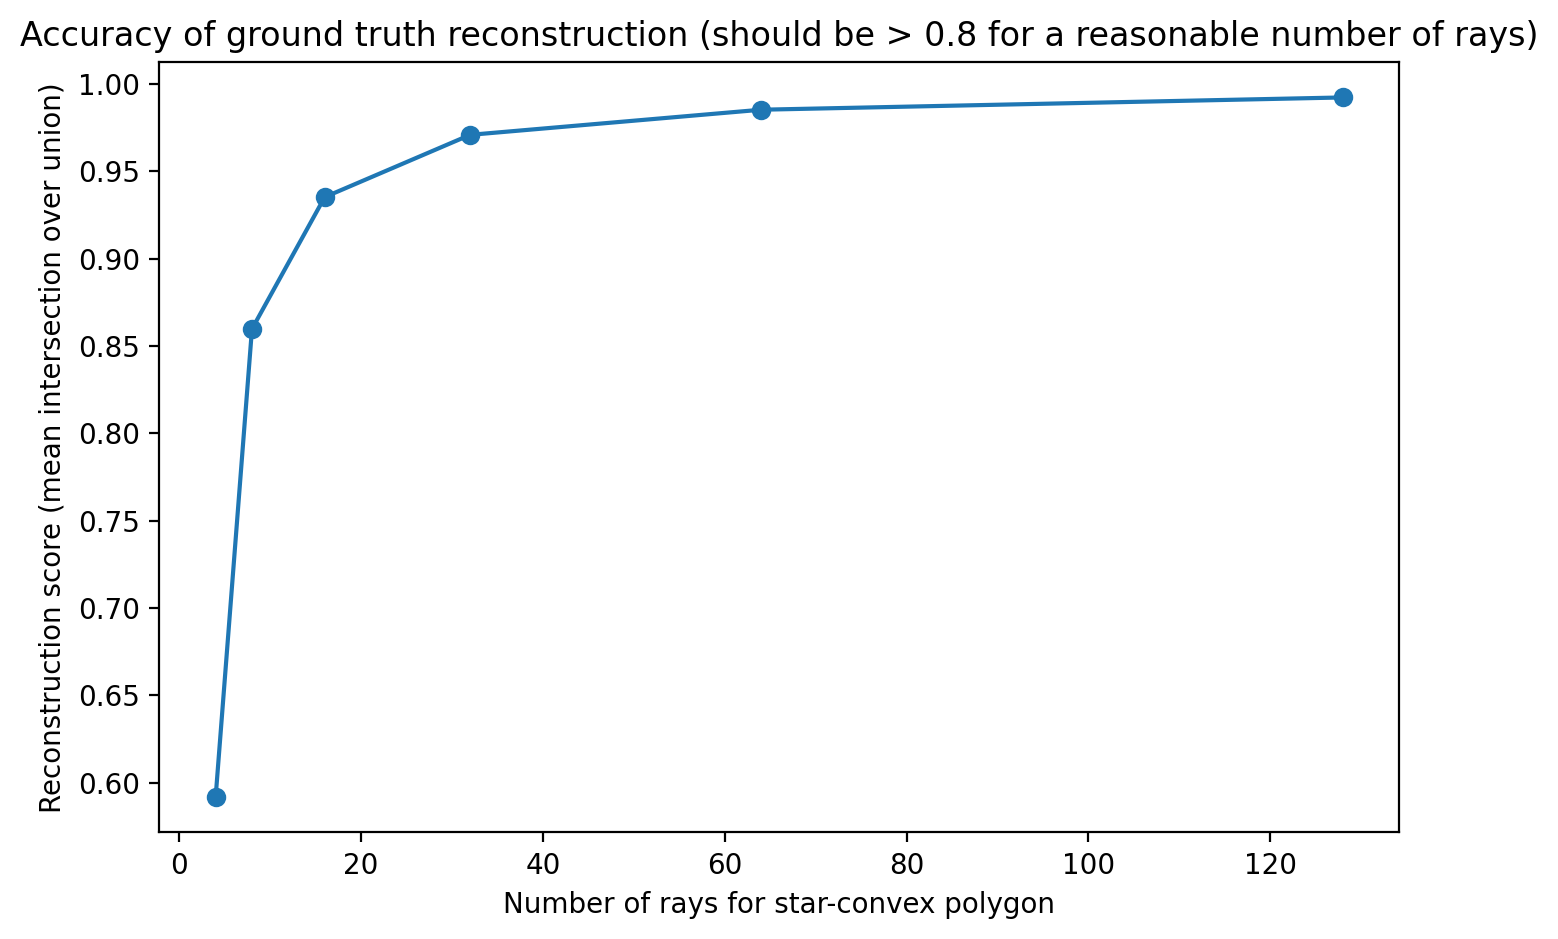

In [16]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.title("Accuracy of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

# Do the Training!
### Below is the different variables we can use to do some training. 

* Alter the number of rays based on how your images look
* If you have memory issues, change the grid size (but default is generally ok)
* Change use_gpu to True if you want to use the GPU for training (you do)
* There are a ton of other variables you can use.  One thing that is often done is transfer learning, where you can use a pre-built model and add data to it to increase it's accuracy


In [16]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #number of rays

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_classes=None, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [17]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    #limit_gpu_memory(0.8)
    # alternatively, try this:
    limit_gpu_memory(None, allow_growth=True)

2024-09-06 16:16:18.162383: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-09-06 16:16:18.376208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1e:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.74GiB deviceMemoryBandwidth: 836.37GiB/s
2024-09-06 16:16:18.376244: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-09-06 16:16:18.503792: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-09-06 16:16:18.503837: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-09-06 16:16:18.568311: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [18]:

model = StarDist2D(conf, name='stardist_Sept_demo', basedir='models')

2024-09-06 16:17:37.017322: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 16:17:37.021147: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1e:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.74GiB deviceMemoryBandwidth: 836.37GiB/s
2024-09-06 16:17:37.021671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2024-09-06 16:17:37.021737: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-09-06 16:17:40.954975: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnec

Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [19]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

2024-09-06 16:17:52.001381: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-09-06 16:17:52.017055: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400000000 Hz
2024-09-06 16:17:52.913940: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-09-06 16:17:53.680756: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8401
2024-09-06 16:17:54.695634: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-09-06 16:17:54.696103: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


median object size:      [17.5 18. ]
network field of view :  [94 93]


# Data Augmentation
You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [20]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

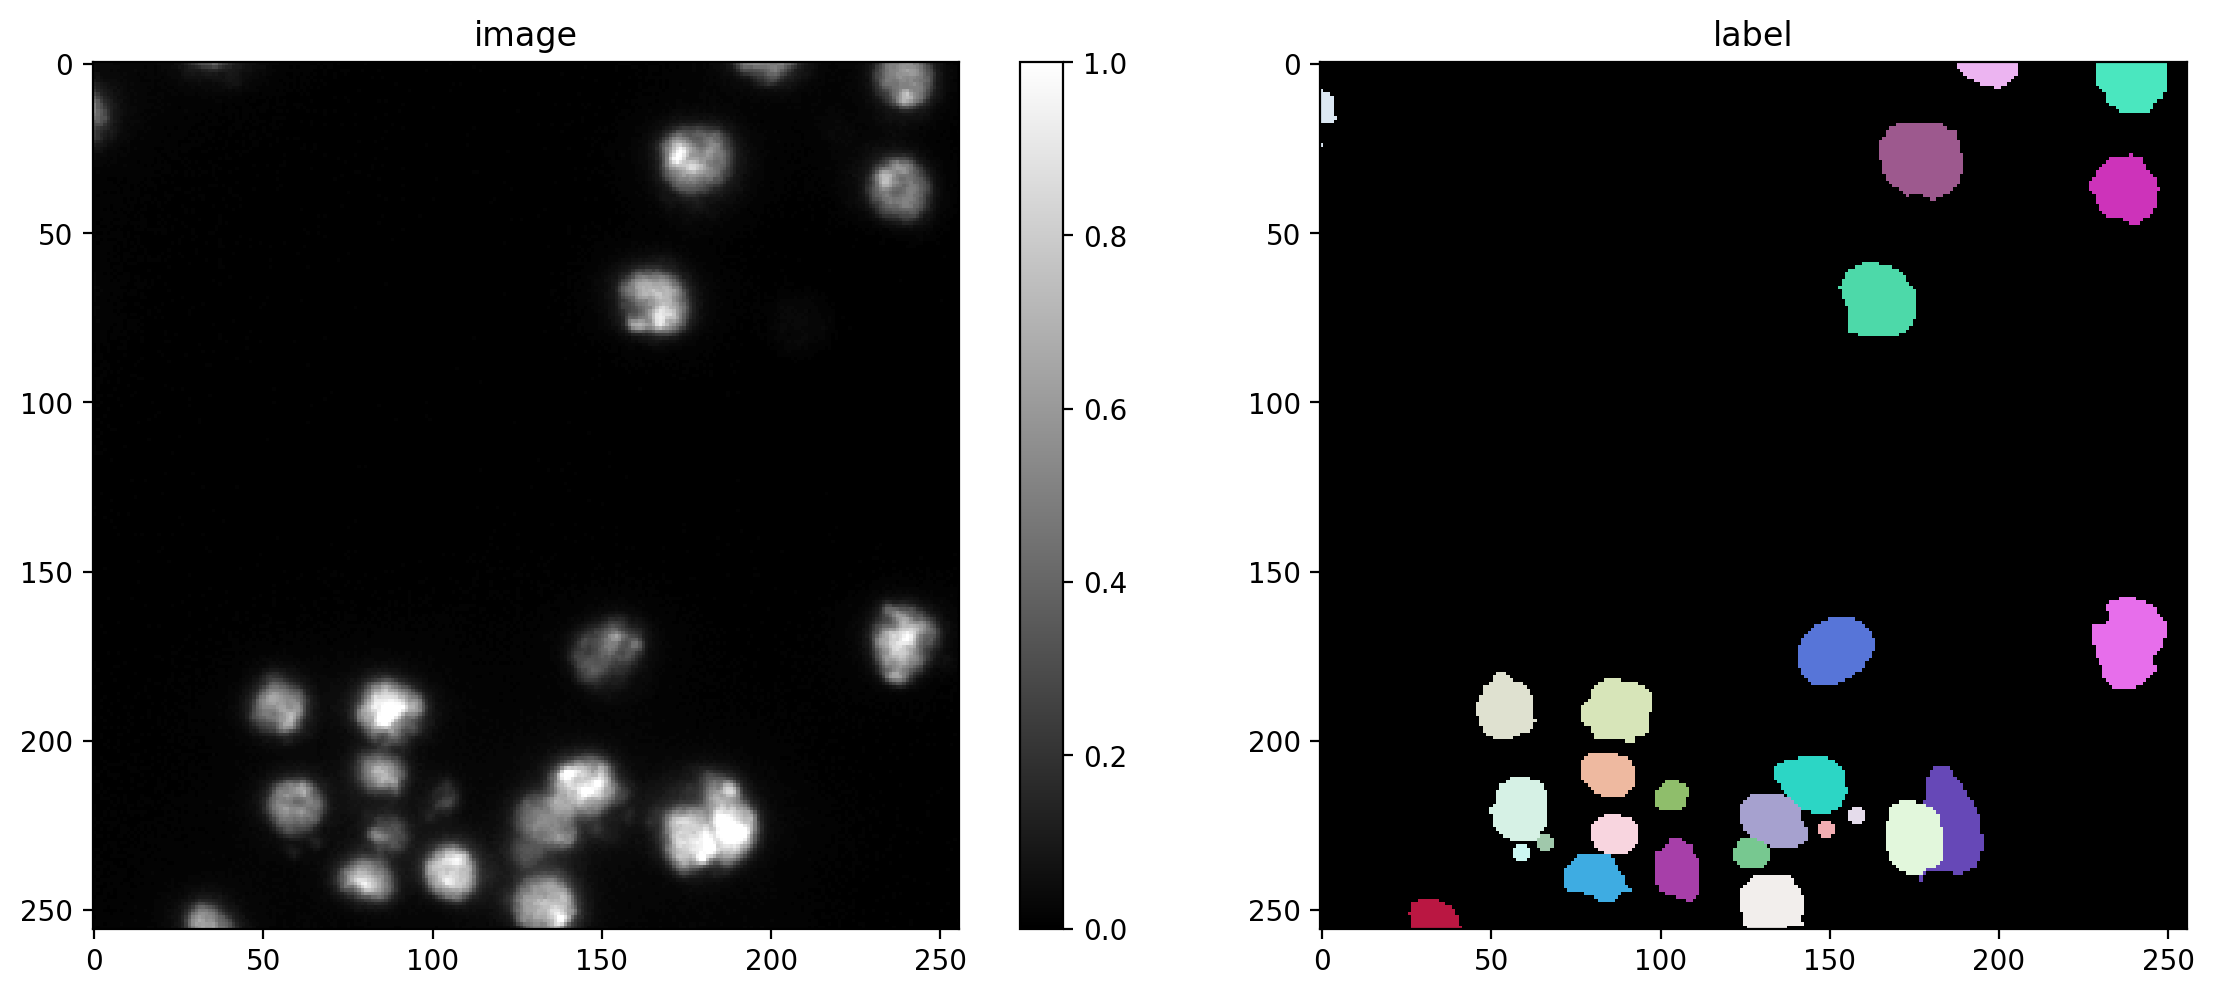

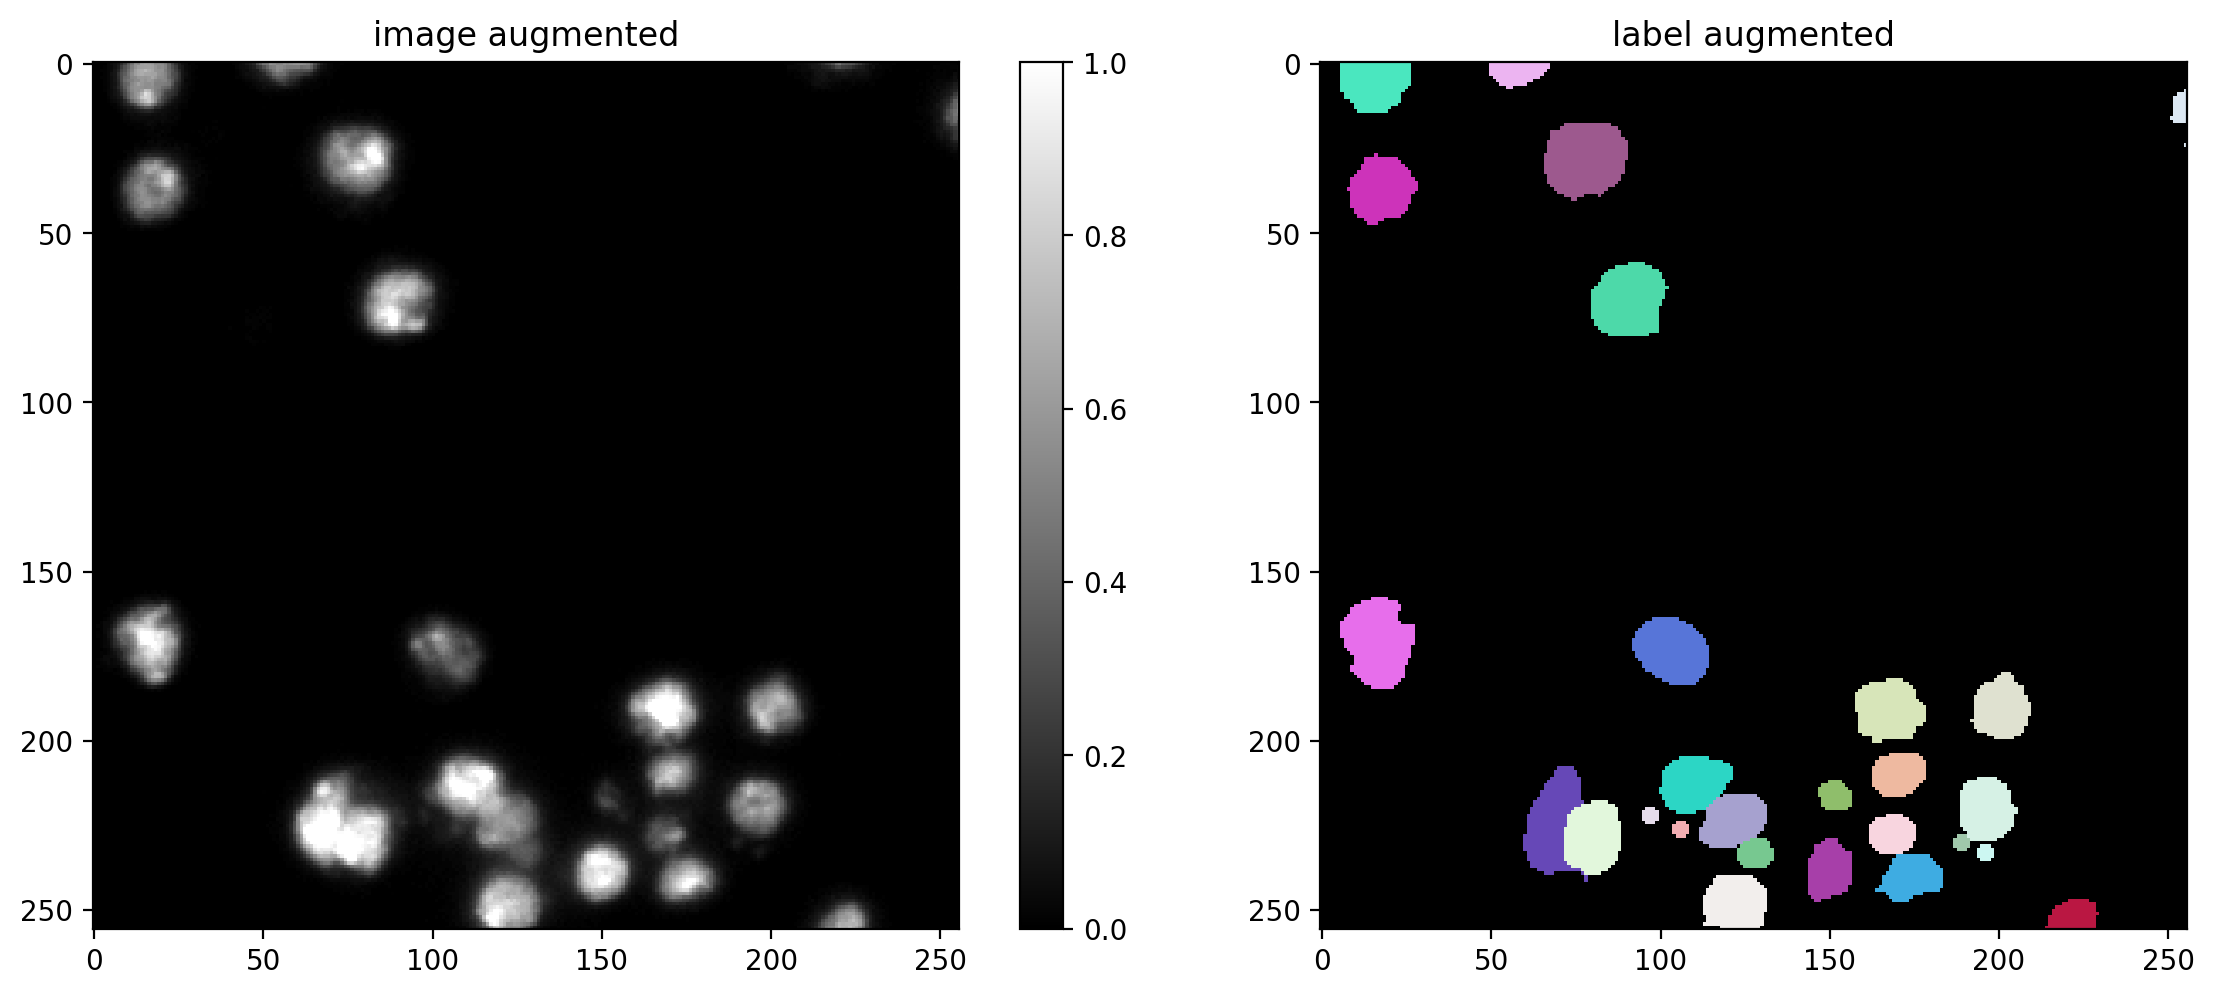

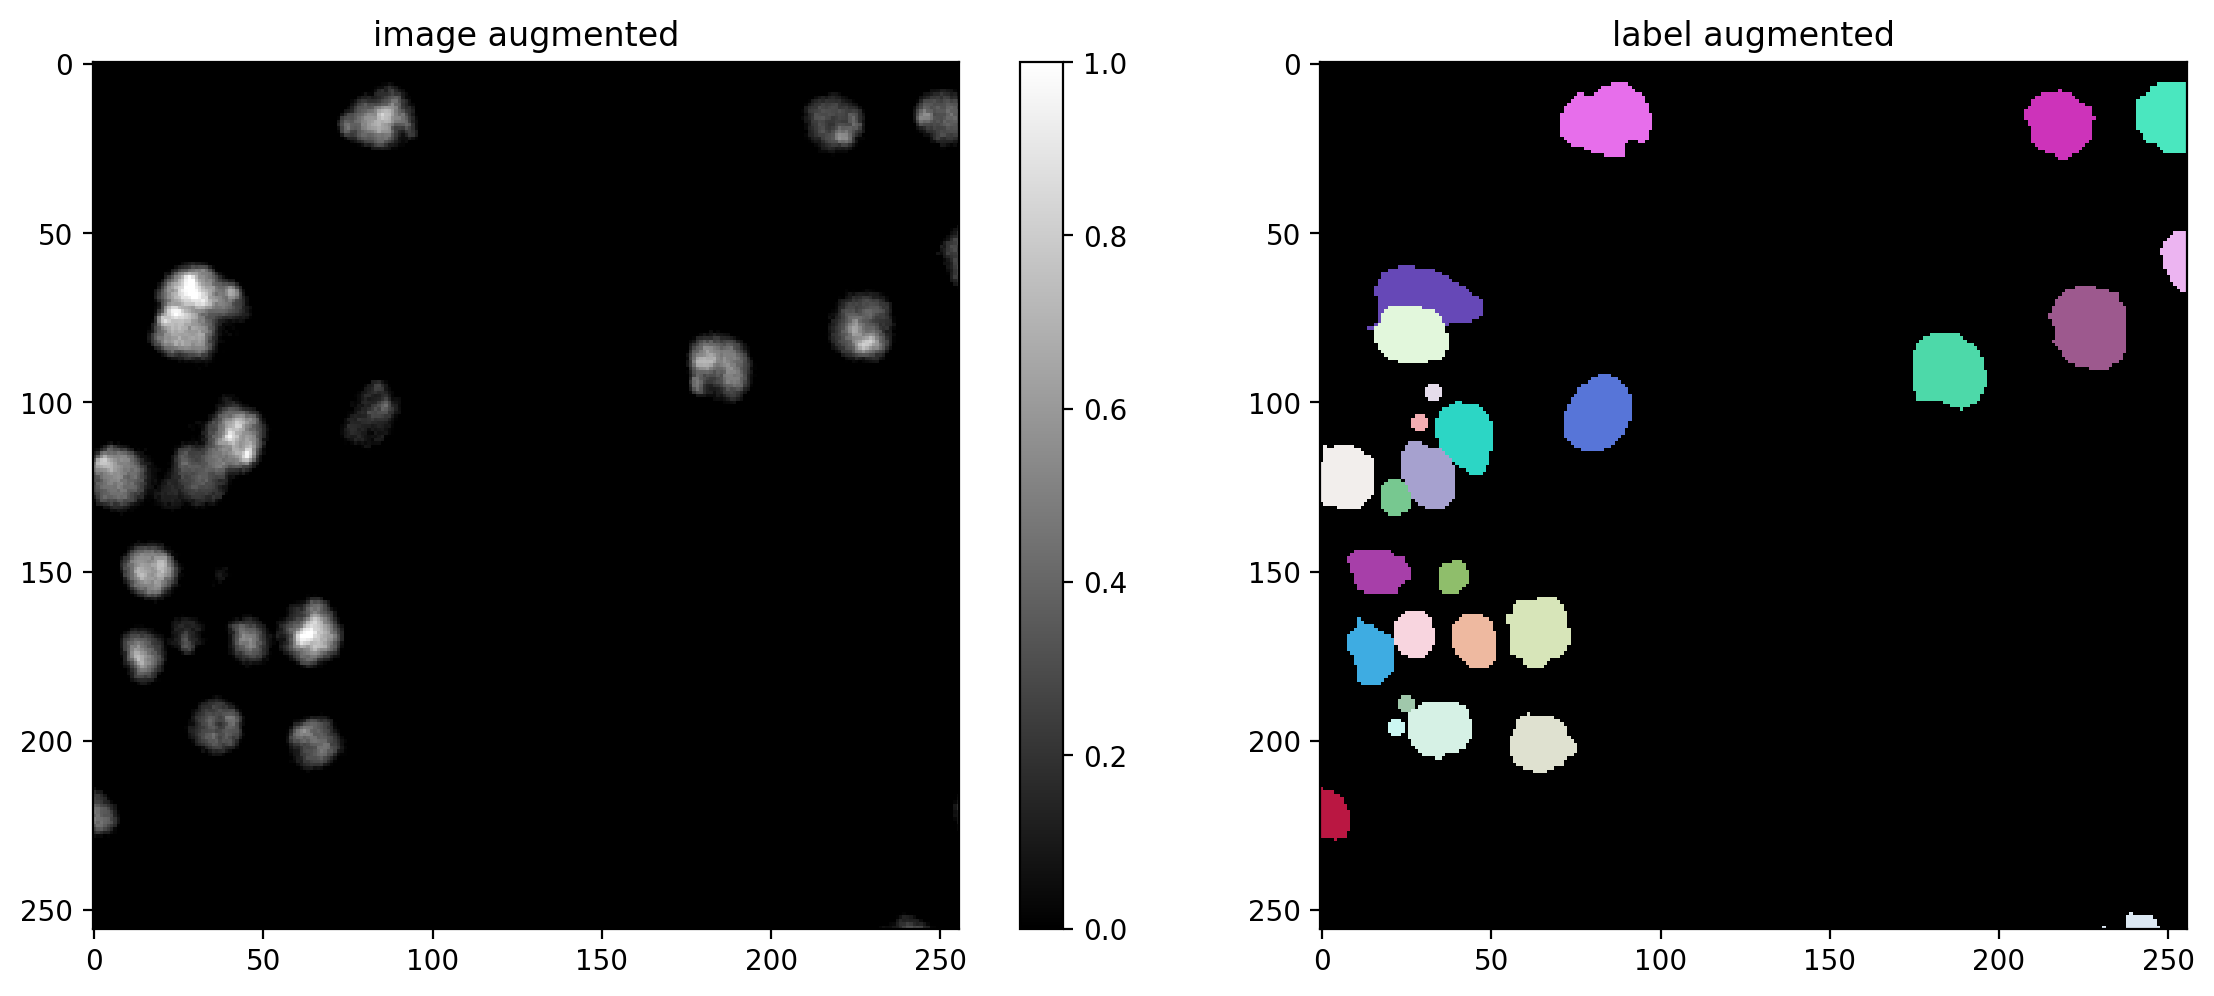

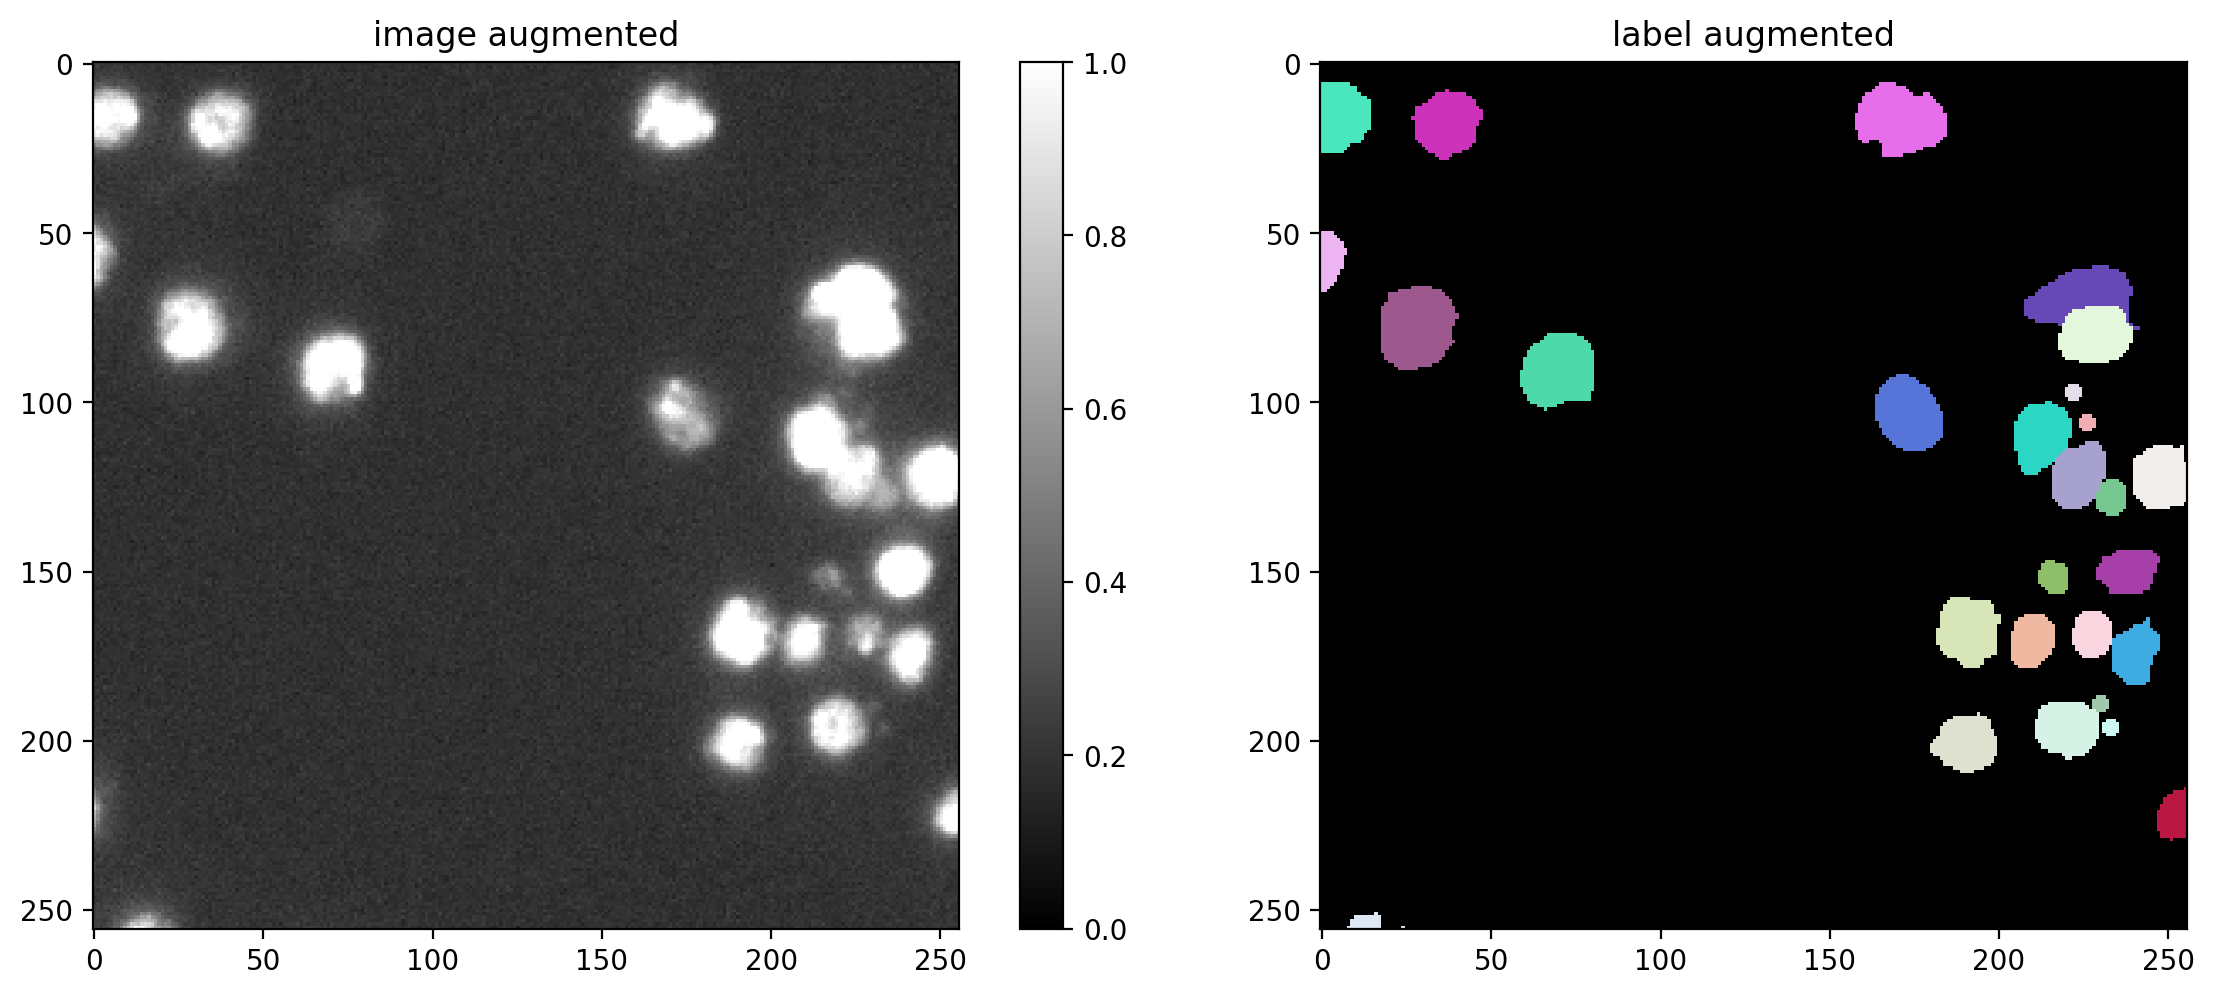

In [37]:
# plot some augmented examples
img, lbl = X[0],Y[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

# Callbacks

Callbacks are functions that you can specify to run during the training, to get a feel for what is going on in the training.  Here, I wrote a Callback that every tenth epoch runs the model "as is" on a validation image, and generates a label image, and saves it to an image path.

There are actually two images generated, a label image, and an image with the labels overlaid on the original image.



In [22]:
from tensorflow.keras.callbacks import Callback


class EvaluateModelCallback(Callback):
    def __init__(self, validation_data, im_path):
        super(EvaluateModelCallback, self).__init__()
        self.validation_data = validation_data
        self.im_path = im_path

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            # Assuming you have a function to evaluate your model on validation data
            Y_val_pred = model.predict_instances(validation_data, n_tiles=model._guess_n_tiles(validation_data), show_tile_progress=False)[0]
            
            # Print or log the evaluation results
            print(f"\nEvaluation results at epoch {epoch}:")
            plt.imshow(validation_data, cmap='gray')
            plt.imshow(Y_val_pred, cmap=lbl_cmap, alpha=0.35)
            #im_path= '/nemo/stp/lm/working/fallest/StarDist_Course_Jan_2024/output_images/gray/'
            filename_tiff = im_path+"Labels_epoch_"+str(epoch)+"_"+model.name+".tiff"
            filename_png = im_path+"Overlay_epoch_"+str(epoch)+"_"+model.name+".png"
            print(filename_tiff)
            plt.imsave(filename_tiff, Y_val_pred, cmap=lbl_cmap)
            plt.savefig(filename_png)
            




In [23]:
#Set the image we want to use for the callback, and the path we want to save the images to
validation_data = X_val[0]
im_path= '/nemo/stp/lm/working/fallest/StarDist_Course_Sept_2024/output_images/gray/'

if not os.path.exists(im_path):  #make the directory if it doesn't exist
    os.makedirs(im_path)



evaluate_callback = EvaluateModelCallback(validation_data, im_path) #set up the callback with the image and the path

### Show the image we're validating on

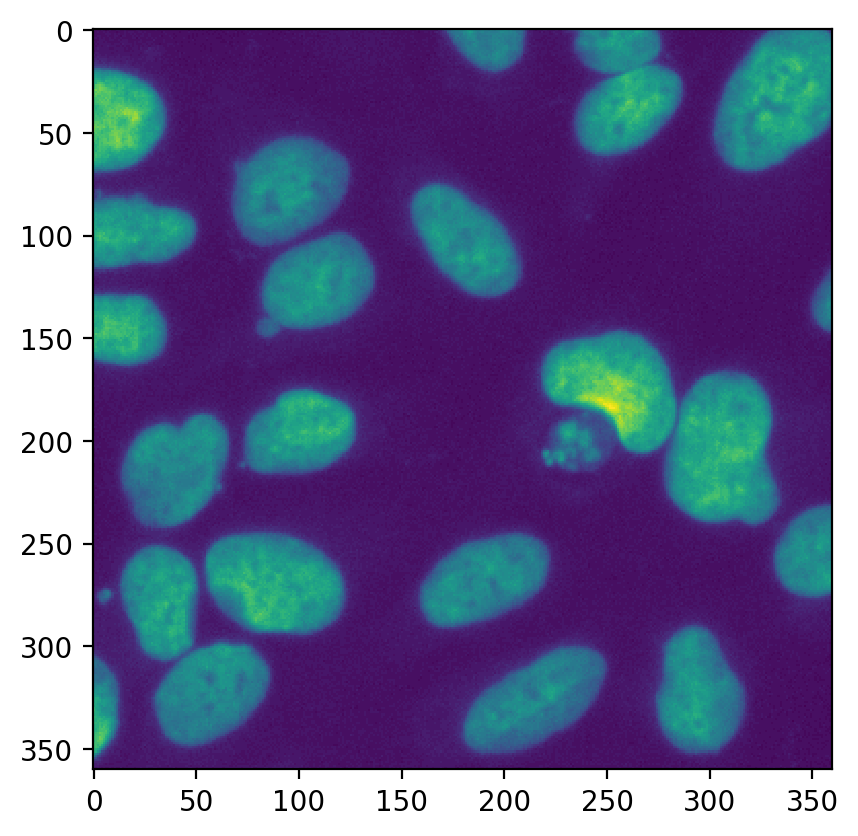

In [24]:
plt.imshow(validation_data)

# Training

## This will take about 1 second per epoch on the cluster, with GPU, at 250GB

Epoch 1/200
20/20 [==============================] - 7s 187ms/step - loss: 3.1216 - prob_loss: 0.4727 - dist_loss: 13.2446 - prob_kld: 0.3937 - dist_relevant_mae: 13.2446 - dist_relevant_mse: 298.8987 - dist_dist_iou_metric: 0.0023 - val_loss: 2.8953 - val_prob_loss: 0.2994 - val_dist_loss: 12.9795 - val_prob_kld: 0.2255 - val_dist_relevant_mae: 12.9794 - val_dist_relevant_mse: 283.9893 - val_dist_dist_iou_metric: 0.0060

Evaluation results at epoch 0:
/nemo/stp/lm/working/fallest/StarDist_Course_Sept_2024/output_images/gray/Labels_epoch_0_stardist_Sept_demo.tiff
Epoch 2/200
20/20 [==============================] - 2s 93ms/step - loss: 2.6437 - prob_loss: 0.3108 - dist_loss: 11.6644 - prob_kld: 0.2386 - dist_relevant_mae: 11.6642 - dist_relevant_mse: 243.2109 - dist_dist_iou_metric: 0.0599 - val_loss: 2.2625 - val_prob_loss: 0.4103 - val_dist_loss: 9.2611 - val_prob_kld: 0.3379 - val_dist_relevant_mae: 9.2605 - val_dist_relevant_mse: 174.8908 - val_dist_dist_iou_metric: 0.2005
Epoch 3/

Epoch 20/200
20/20 [==============================] - 1s 66ms/step - loss: 1.1597 - prob_loss: 0.1624 - dist_loss: 4.9867 - prob_kld: 0.0980 - dist_relevant_mae: 4.9858 - dist_relevant_mse: 63.6318 - dist_dist_iou_metric: 0.4842 - val_loss: 0.9320 - val_prob_loss: 0.1355 - val_dist_loss: 3.9823 - val_prob_kld: 0.0626 - val_dist_relevant_mae: 3.9815 - val_dist_relevant_mse: 40.7237 - val_dist_dist_iou_metric: 0.5507
Epoch 21/200
20/20 [==============================] - 3s 164ms/step - loss: 0.9350 - prob_loss: 0.1537 - dist_loss: 3.9066 - prob_kld: 0.0804 - dist_relevant_mae: 3.9058 - dist_relevant_mse: 39.4855 - dist_dist_iou_metric: 0.5264 - val_loss: 0.9405 - val_prob_loss: 0.1254 - val_dist_loss: 4.0754 - val_prob_kld: 0.0526 - val_dist_relevant_mae: 4.0744 - val_dist_relevant_mse: 36.6700 - val_dist_dist_iou_metric: 0.5634

Evaluation results at epoch 20:
/nemo/stp/lm/working/fallest/StarDist_Course_Sept_2024/output_images/gray/Labels_epoch_20_stardist_Sept_demo.tiff
Epoch 22/200
2

Epoch 39/200
20/20 [==============================] - 2s 112ms/step - loss: 0.8427 - prob_loss: 0.1130 - dist_loss: 3.6486 - prob_kld: 0.0295 - dist_relevant_mae: 3.6478 - dist_relevant_mse: 35.7484 - dist_dist_iou_metric: 0.6114 - val_loss: 0.7711 - val_prob_loss: 0.0979 - val_dist_loss: 3.3663 - val_prob_kld: 0.0251 - val_dist_relevant_mae: 3.3654 - val_dist_relevant_mse: 26.2631 - val_dist_dist_iou_metric: 0.6350
Epoch 40/200
20/20 [==============================] - 2s 99ms/step - loss: 0.7422 - prob_loss: 0.1049 - dist_loss: 3.1865 - prob_kld: 0.0279 - dist_relevant_mae: 3.1857 - dist_relevant_mse: 26.8017 - dist_dist_iou_metric: 0.5993 - val_loss: 0.8459 - val_prob_loss: 0.0940 - val_dist_loss: 3.7594 - val_prob_kld: 0.0212 - val_dist_relevant_mae: 3.7587 - val_dist_relevant_mse: 36.9964 - val_dist_dist_iou_metric: 0.5277
Epoch 41/200
20/20 [==============================] - 2s 118ms/step - loss: 0.7291 - prob_loss: 0.0984 - dist_loss: 3.1532 - prob_kld: 0.0220 - dist_relevant_mae

Epoch 58/200
20/20 [==============================] - 2s 79ms/step - loss: 0.7324 - prob_loss: 0.1067 - dist_loss: 3.1283 - prob_kld: 0.0277 - dist_relevant_mae: 3.1277 - dist_relevant_mse: 27.4892 - dist_dist_iou_metric: 0.6526 - val_loss: 0.6531 - val_prob_loss: 0.0936 - val_dist_loss: 2.7975 - val_prob_kld: 0.0209 - val_dist_relevant_mae: 2.7967 - val_dist_relevant_mse: 23.0121 - val_dist_dist_iou_metric: 0.6420
Epoch 59/200
20/20 [==============================] - 2s 95ms/step - loss: 0.7149 - prob_loss: 0.1275 - dist_loss: 2.9369 - prob_kld: 0.0321 - dist_relevant_mae: 2.9361 - dist_relevant_mse: 24.2908 - dist_dist_iou_metric: 0.6469 - val_loss: 0.6609 - val_prob_loss: 0.0898 - val_dist_loss: 2.8555 - val_prob_kld: 0.0171 - val_dist_relevant_mae: 2.8549 - val_dist_relevant_mse: 24.0273 - val_dist_dist_iou_metric: 0.6428
Epoch 60/200
20/20 [==============================] - 3s 148ms/step - loss: 0.5858 - prob_loss: 0.0860 - dist_loss: 2.4988 - prob_kld: 0.0178 - dist_relevant_mae:

Epoch 77/200
20/20 [==============================] - 2s 88ms/step - loss: 0.6520 - prob_loss: 0.0908 - dist_loss: 2.8062 - prob_kld: 0.0160 - dist_relevant_mae: 2.8057 - dist_relevant_mse: 22.3327 - dist_dist_iou_metric: 0.6648 - val_loss: 0.6020 - val_prob_loss: 0.0872 - val_dist_loss: 2.5743 - val_prob_kld: 0.0145 - val_dist_relevant_mae: 2.5737 - val_dist_relevant_mse: 19.7155 - val_dist_dist_iou_metric: 0.6815
Epoch 78/200
20/20 [==============================] - 3s 143ms/step - loss: 0.7343 - prob_loss: 0.1142 - dist_loss: 3.1003 - prob_kld: 0.0257 - dist_relevant_mae: 3.0997 - dist_relevant_mse: 26.0630 - dist_dist_iou_metric: 0.6430 - val_loss: 0.6275 - val_prob_loss: 0.0897 - val_dist_loss: 2.6889 - val_prob_kld: 0.0170 - val_dist_relevant_mae: 2.6882 - val_dist_relevant_mse: 19.0343 - val_dist_dist_iou_metric: 0.6561
Epoch 79/200
20/20 [==============================] - 3s 154ms/step - loss: 0.6700 - prob_loss: 0.1066 - dist_loss: 2.8168 - prob_kld: 0.0280 - dist_relevant_mae

Epoch 96/200
20/20 [==============================] - 2s 84ms/step - loss: 0.6154 - prob_loss: 0.0940 - dist_loss: 2.6071 - prob_kld: 0.0190 - dist_relevant_mae: 2.6066 - dist_relevant_mse: 21.0559 - dist_dist_iou_metric: 0.6805 - val_loss: 0.6634 - val_prob_loss: 0.0917 - val_dist_loss: 2.8583 - val_prob_kld: 0.0190 - val_dist_relevant_mae: 2.8577 - val_dist_relevant_mse: 19.3264 - val_dist_dist_iou_metric: 0.6805
Epoch 97/200
20/20 [==============================] - 1s 72ms/step - loss: 0.6970 - prob_loss: 0.1008 - dist_loss: 2.9811 - prob_kld: 0.0283 - dist_relevant_mae: 2.9805 - dist_relevant_mse: 23.5262 - dist_dist_iou_metric: 0.6195 - val_loss: 0.7369 - val_prob_loss: 0.0913 - val_dist_loss: 3.2281 - val_prob_kld: 0.0186 - val_dist_relevant_mae: 3.2275 - val_dist_relevant_mse: 30.1825 - val_dist_dist_iou_metric: 0.6164
Epoch 98/200
20/20 [==============================] - 3s 131ms/step - loss: 0.6241 - prob_loss: 0.0925 - dist_loss: 2.6582 - prob_kld: 0.0211 - dist_relevant_mae:

Epoch 115/200
20/20 [==============================] - 2s 85ms/step - loss: 0.5309 - prob_loss: 0.0733 - dist_loss: 2.2879 - prob_kld: 0.0161 - dist_relevant_mae: 2.2874 - dist_relevant_mse: 16.0534 - dist_dist_iou_metric: 0.6824 - val_loss: 0.5622 - val_prob_loss: 0.0874 - val_dist_loss: 2.3739 - val_prob_kld: 0.0147 - val_dist_relevant_mae: 2.3734 - val_dist_relevant_mse: 16.4691 - val_dist_dist_iou_metric: 0.7037
Epoch 116/200
20/20 [==============================] - 2s 129ms/step - loss: 0.5679 - prob_loss: 0.1075 - dist_loss: 2.3021 - prob_kld: 0.0230 - dist_relevant_mae: 2.3017 - dist_relevant_mse: 15.4055 - dist_dist_iou_metric: 0.6883 - val_loss: 0.5354 - val_prob_loss: 0.0868 - val_dist_loss: 2.2431 - val_prob_kld: 0.0141 - val_dist_relevant_mae: 2.2426 - val_dist_relevant_mse: 15.5195 - val_dist_dist_iou_metric: 0.7140
Epoch 117/200
20/20 [==============================] - 5s 246ms/step - loss: 0.5598 - prob_loss: 0.0992 - dist_loss: 2.3026 - prob_kld: 0.0187 - dist_relevant_

Epoch 134/200
20/20 [==============================] - 2s 125ms/step - loss: 0.5115 - prob_loss: 0.0903 - dist_loss: 2.1062 - prob_kld: 0.0204 - dist_relevant_mae: 2.1056 - dist_relevant_mse: 12.5749 - dist_dist_iou_metric: 0.7115 - val_loss: 0.5662 - val_prob_loss: 0.0888 - val_dist_loss: 2.3869 - val_prob_kld: 0.0161 - val_dist_relevant_mae: 2.3863 - val_dist_relevant_mse: 15.9404 - val_dist_dist_iou_metric: 0.6840
Epoch 135/200
20/20 [==============================] - 1s 69ms/step - loss: 0.5901 - prob_loss: 0.1090 - dist_loss: 2.4054 - prob_kld: 0.0293 - dist_relevant_mae: 2.4049 - dist_relevant_mse: 17.3721 - dist_dist_iou_metric: 0.7019 - val_loss: 0.5580 - val_prob_loss: 0.0872 - val_dist_loss: 2.3541 - val_prob_kld: 0.0145 - val_dist_relevant_mae: 2.3536 - val_dist_relevant_mse: 13.9788 - val_dist_dist_iou_metric: 0.7179
Epoch 136/200
20/20 [==============================] - 3s 137ms/step - loss: 0.6083 - prob_loss: 0.1051 - dist_loss: 2.5159 - prob_kld: 0.0213 - dist_relevant_

Epoch 153/200
20/20 [==============================] - 1s 65ms/step - loss: 0.5271 - prob_loss: 0.0971 - dist_loss: 2.1500 - prob_kld: 0.0185 - dist_relevant_mae: 2.1496 - dist_relevant_mse: 14.1329 - dist_dist_iou_metric: 0.7227 - val_loss: 0.4990 - val_prob_loss: 0.0851 - val_dist_loss: 2.0697 - val_prob_kld: 0.0124 - val_dist_relevant_mae: 2.0692 - val_dist_relevant_mse: 12.1622 - val_dist_dist_iou_metric: 0.7380
Epoch 154/200
20/20 [==============================] - 3s 170ms/step - loss: 0.5030 - prob_loss: 0.1021 - dist_loss: 2.0041 - prob_kld: 0.0191 - dist_relevant_mae: 2.0036 - dist_relevant_mse: 11.6976 - dist_dist_iou_metric: 0.7192 - val_loss: 0.4907 - val_prob_loss: 0.0857 - val_dist_loss: 2.0250 - val_prob_kld: 0.0130 - val_dist_relevant_mae: 2.0246 - val_dist_relevant_mse: 12.6361 - val_dist_dist_iou_metric: 0.7326
Epoch 155/200
20/20 [==============================] - 3s 165ms/step - loss: 0.4900 - prob_loss: 0.0838 - dist_loss: 2.0312 - prob_kld: 0.0151 - dist_relevant_

Epoch 172/200
20/20 [==============================] - 3s 162ms/step - loss: 0.5060 - prob_loss: 0.0950 - dist_loss: 2.0552 - prob_kld: 0.0153 - dist_relevant_mae: 2.0548 - dist_relevant_mse: 11.9958 - dist_dist_iou_metric: 0.7345 - val_loss: 0.4813 - val_prob_loss: 0.0852 - val_dist_loss: 1.9803 - val_prob_kld: 0.0126 - val_dist_relevant_mae: 1.9799 - val_dist_relevant_mse: 11.5126 - val_dist_dist_iou_metric: 0.7434
Epoch 173/200
20/20 [==============================] - 2s 102ms/step - loss: 0.4625 - prob_loss: 0.0889 - dist_loss: 1.8678 - prob_kld: 0.0152 - dist_relevant_mae: 1.8673 - dist_relevant_mse: 10.4882 - dist_dist_iou_metric: 0.7410 - val_loss: 0.4842 - val_prob_loss: 0.0858 - val_dist_loss: 1.9917 - val_prob_kld: 0.0131 - val_dist_relevant_mae: 1.9912 - val_dist_relevant_mse: 11.5202 - val_dist_dist_iou_metric: 0.7307
Epoch 174/200
20/20 [==============================] - 1s 71ms/step - loss: 0.5170 - prob_loss: 0.0953 - dist_loss: 2.1086 - prob_kld: 0.0167 - dist_relevant_

20/20 [==============================] - 1s 63ms/step - loss: 0.4855 - prob_loss: 0.0915 - dist_loss: 1.9699 - prob_kld: 0.0147 - dist_relevant_mae: 1.9695 - dist_relevant_mse: 10.7699 - dist_dist_iou_metric: 0.7327 - val_loss: 0.4656 - val_prob_loss: 0.0861 - val_dist_loss: 1.8976 - val_prob_kld: 0.0134 - val_dist_relevant_mae: 1.8971 - val_dist_relevant_mse: 10.4972 - val_dist_dist_iou_metric: 0.7464

Evaluation results at epoch 190:
/nemo/stp/lm/working/fallest/StarDist_Course_Sept_2024/output_images/gray/Labels_epoch_190_stardist_Sept_demo.tiff
Epoch 192/200
20/20 [==============================] - 1s 61ms/step - loss: 0.4801 - prob_loss: 0.0839 - dist_loss: 1.9809 - prob_kld: 0.0126 - dist_relevant_mae: 1.9805 - dist_relevant_mse: 11.9088 - dist_dist_iou_metric: 0.7517 - val_loss: 0.4627 - val_prob_loss: 0.0849 - val_dist_loss: 1.8890 - val_prob_kld: 0.0122 - val_dist_relevant_mae: 1.8885 - val_dist_relevant_mse: 9.7865 - val_dist_dist_iou_metric: 0.7559
Epoch 193/200
20/20 [=====

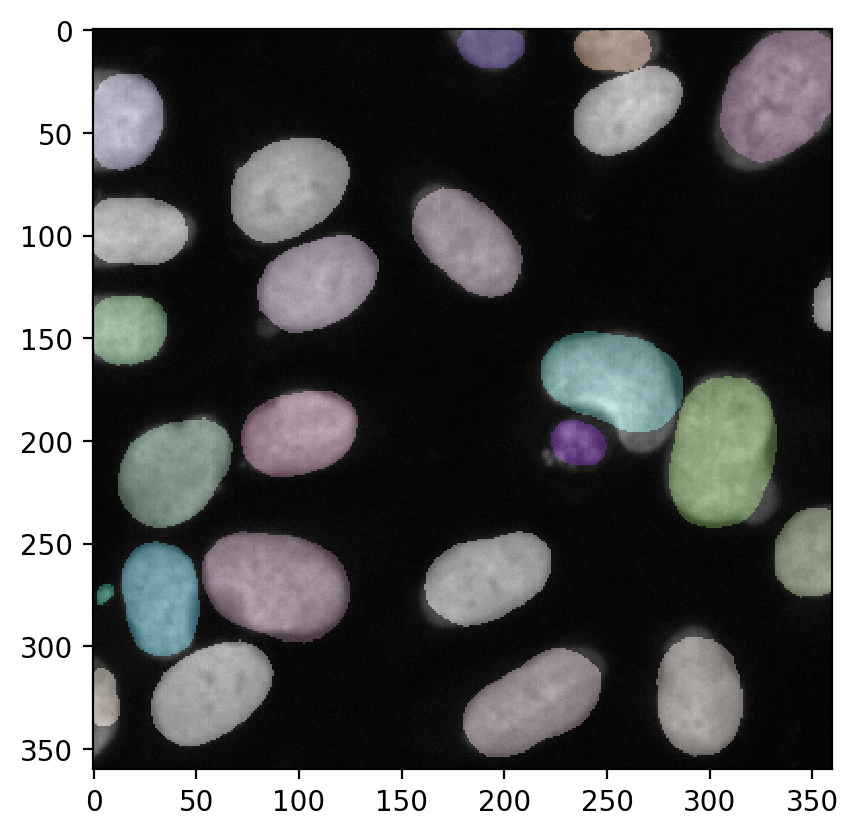

In [25]:
quick_demo = False
#if false!
if quick_demo==False:
    epochs=200
    steps=20

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=10)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model.prepare_for_training() # open up the model for adding callbacks
    model.callbacks.append(evaluate_callback) #add our callback
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=epochs, steps_per_epoch=steps)
None;

# Metrics:
The code for the metrics can be found in : https://github.com/stardist/stardist/blob/master/stardist/models/base.py

In the above computations, you'll see the same metric twice, i.e. loss and val_loss.  In this case, loss is the loss computed on the training set, and val_loss is the loss computed on the validation set.

Some of the metrics that will help you understand what's going on are:

* loss - Measure of how well the model is performing, the error between the predicted values and ground truth. We want this value to be low

* prob_kld - Kullback-Leibler Divergence. This measures the divergence between two probability distributions, in this case the predicted probability distribution and the expected probability distributions. This should be low

* iou_metric - The intersection over union.  The closer to 1 this is, the better

* mae - Mean absolute error, difference between predicted and ground truth. This should decrease over time.

* mse - Mean squared error of difference between predicted and ground truth. This should decrease over time.



In [26]:
if quick_demo:
    model.optimize_thresholds(X_val[:2], Y_val[:2])
else:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████▊ | 16/20 [00:31<00:07,  1.98s/it, 0.456 -> 0.770]


Using optimized values: prob_thresh=0.454248, nms_thresh=0.4.
Saving to 'thresholds.json'.


# Evaluation and Detection Performance
Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.


The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 

### Tau: Tau is the IoU threshold.  

### The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [27]:
#help(matching)

### First predict the labels for all validation images:

In [28]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|███████████████████████████████████████████| 67/67 [00:06<00:00, 10.69it/s]


Plot a GT/prediction example 

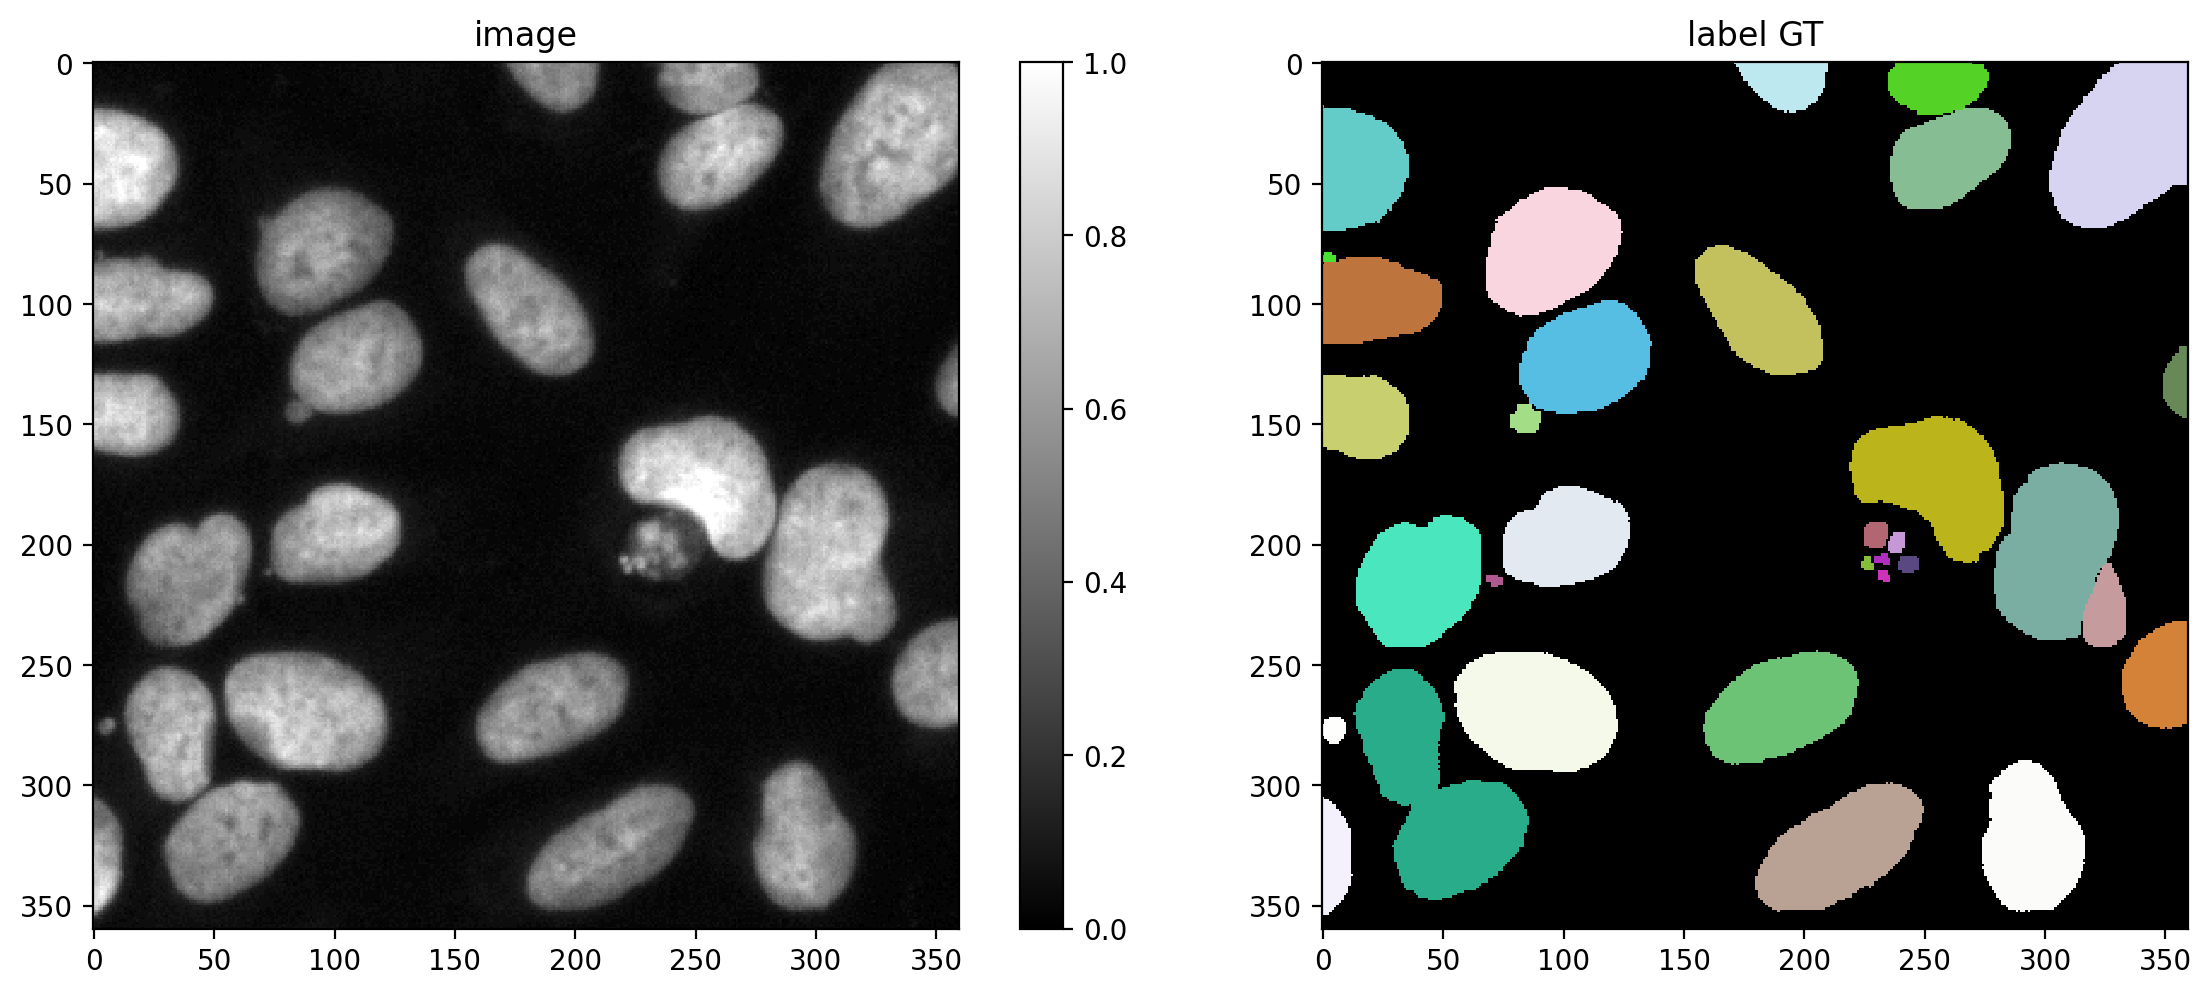

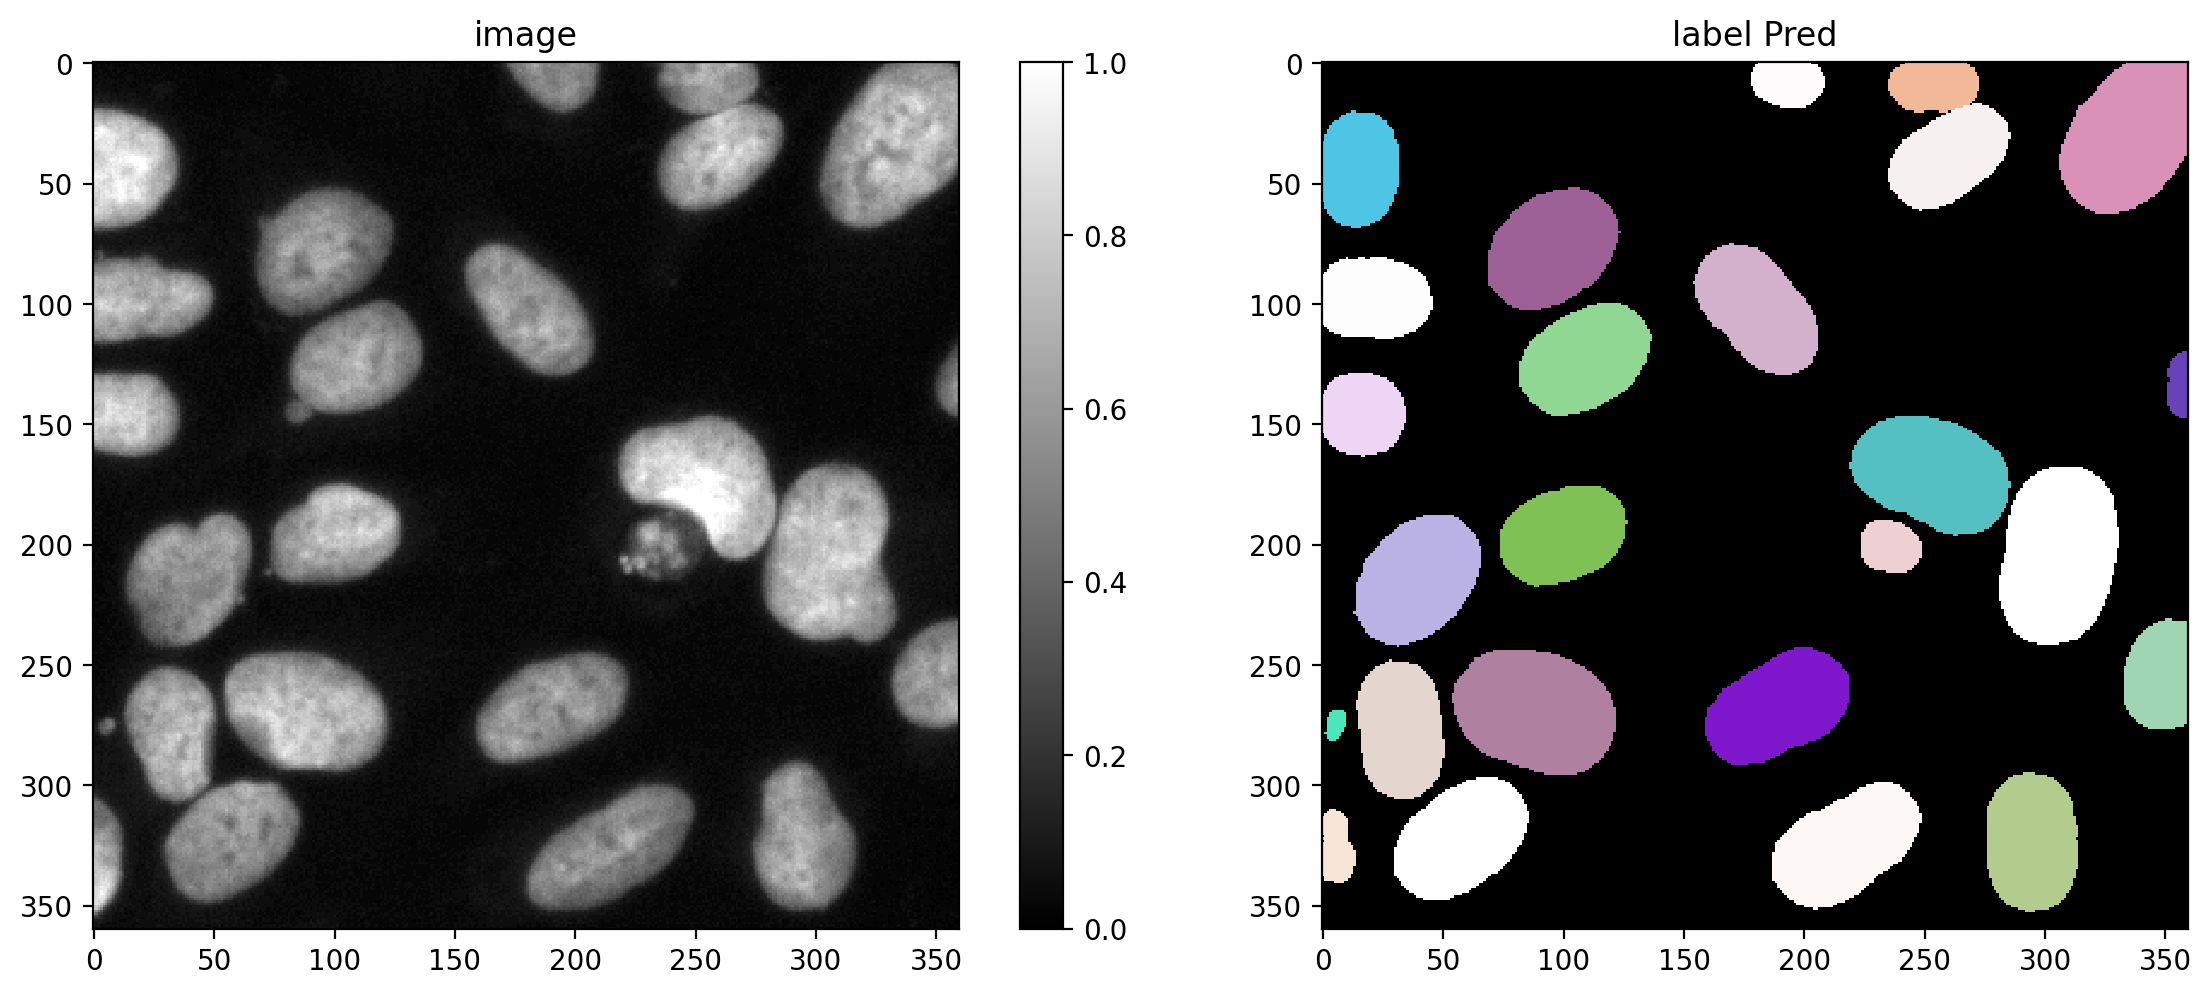

In [29]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")

## Compare ground truth labels to predicted labels

### Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

#### You can, and should, do this as well with data you hold in a separate folder from the training images, to make sure there is no data leakage

In [30]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]
#Y_Val is your ground truth labels, Y_Val_predicted is the predictions of the labels.  This function compares them!

100%|█████████████████████████████████████████████| 9/9 [00:03<00:00,  2.80it/s]


## Example: Print all available matching statistics for $\tau=0.5$

In [31]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=133, tp=2229, fn=314, precision=0.9436917866215072, recall=0.8765237907982698, accuracy=0.8329596412556054, f1=0.908868501529052, n_true=2543, n_pred=2362, mean_true_score=0.7134646062442181, mean_matched_score=0.8139706117896127, panoptic_quality=0.739792250225911, by_image=False)

### Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

* False positives are the number of objects that are identified that aren't there in reality.
* False negatives are the objects that are missed by the algorithm
* True positives are the ones that are correct

* Precision = tp/(tp+fp) 
* Recall = tp/(tp+fn)
* Accuracy = tp/(tp+fp+fn)
* f1 = (2 * tp)/((2 * tp)+fp+fn)



### As we increase tau, we tend to get many more false negatives and less true positives, as we are requiring the matches to be more and more perfect

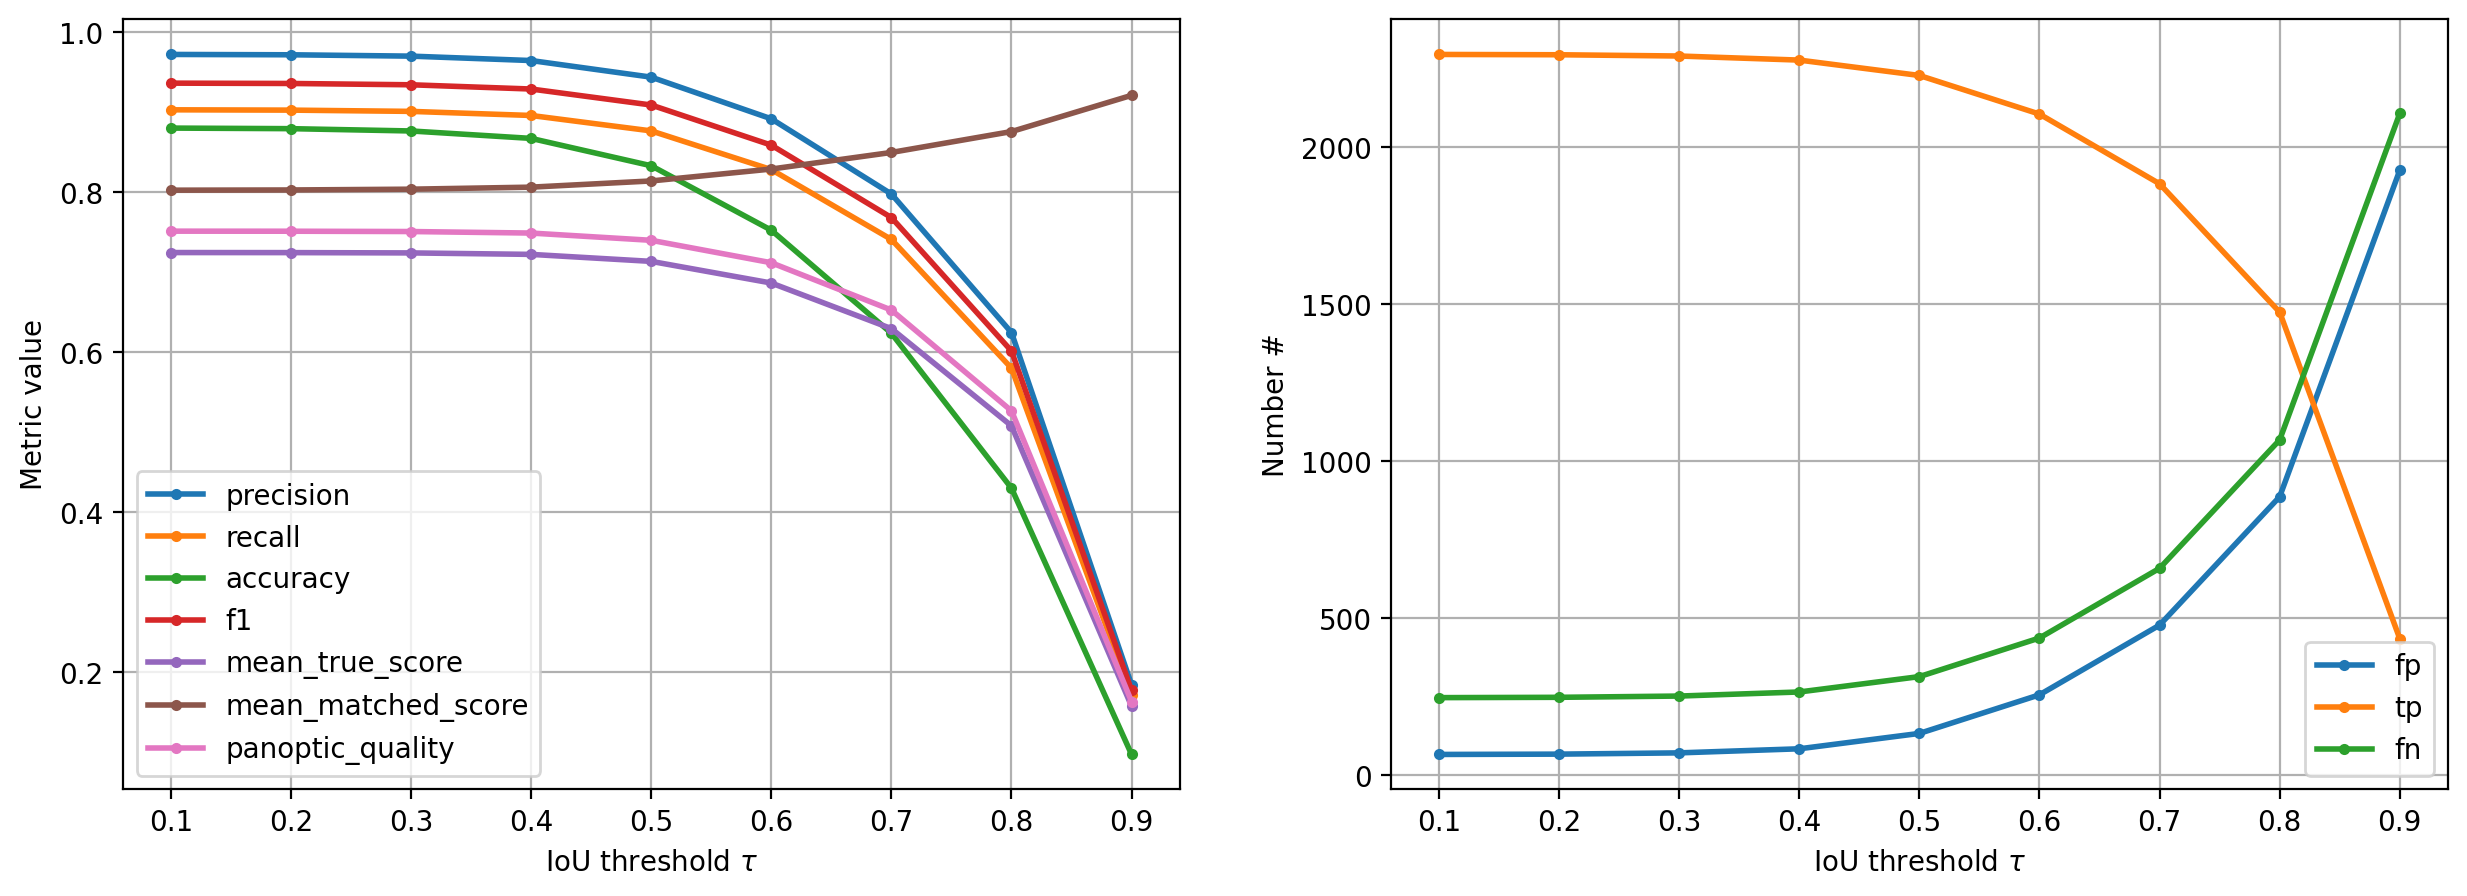

In [32]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In the **StarDist** framework, which is commonly used for instance segmentation of cells or objects in biological images, several evaluation metrics are utilized to assess the quality of segmentation. Here's a breakdown of these metrics in the context of **StarDist** and panoptic segmentation:

### 1. **Precision**
   - Precision is the proportion of correctly identified objects (true positives) out of all the objects identified by the model (true positives + false positives).


### 2. **Recall**
   - Recall measures how well the model identifies all true objects. It's the proportion of correctly identified objects out of all true objects (true positives + false negatives).


### 3. **Accuracy**
   - Accuracy represents the proportion of correctly classified instances (both true positives and true negatives) out of all instances.
   - However, in segmentation, accuracy may not be as relevant due to class imbalance (e.g., background pixels dominate).

### 4. **F1 Score**
   - The F1 score is the harmonic mean of precision and recall, providing a balance between the two.
   - It helps when there is a need to balance precision and recall.

### 5. **Mean True Score (MTS)**
   - **Mean True Score** is specific to StarDist and related instance segmentation techniques. It is the average intersection-over-union (IoU) score between the ground truth and predicted objects, considering only the true positives (matched pairs).

### 6. **Mean Matched Score (MMS)**
   - **Mean Matched Score** is similar to MTS but also considers both true positives and false positives. It calculates the average IoU for all matched predictions (including false positives).

### 7. **Panoptic Quality (PQ)**
   - **Panoptic Quality** is a unified metric that evaluates both the detection (precision) and segmentation (accuracy) quality of instance segmentation models.



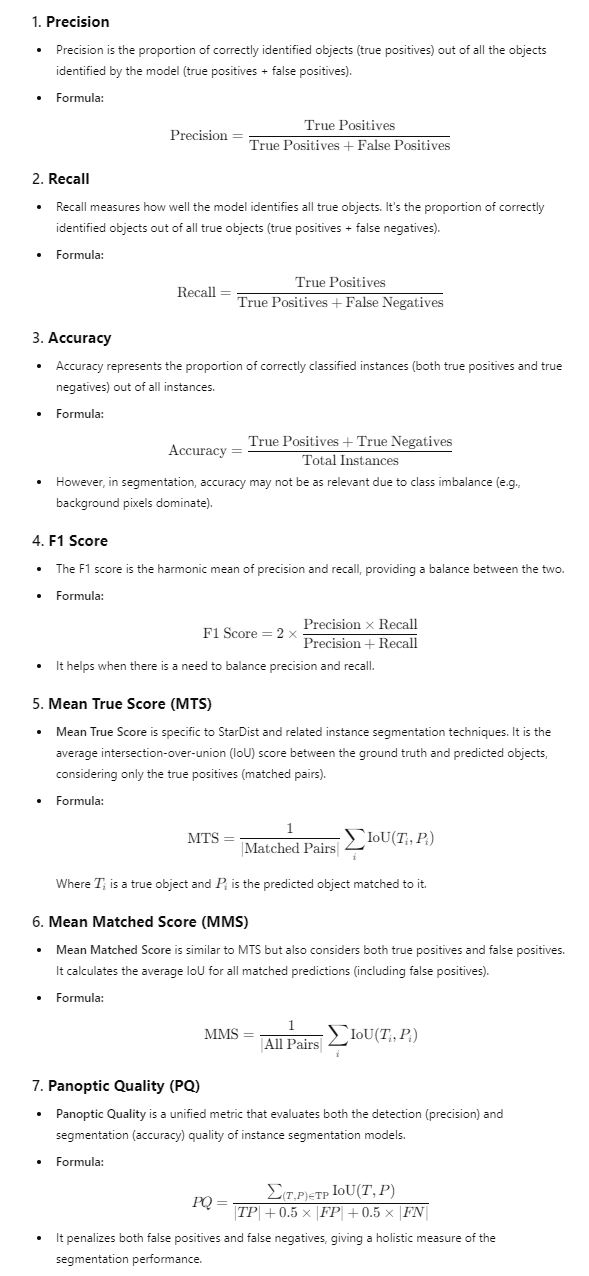

In [44]:
from IPython.display import Image
Image("stardist_metrics.JPG")
#I got this from chatgpt as I didn't feel like writing out these equations

In [ ]:
#harmonic mean = n/(1/x1 + 1/x2 ...) emphasizes smaller numbers, good for ratios